# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import random
import pickle
import requests
import warnings
import numpy as np
import seaborn as sns
import xgboost as xgb
from IPython.core.display         import HTML
from IPython.display              import Image
from scipy                        import stats as ss
from sklearn.preprocessing        import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                       import BorutaPy
from sklearn.ensemble             import RandomForestRegressor
from sklearn.metrics              import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model         import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

/home/felipe/anaconda3/envs/ds_prod/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
# def mean_absolute_percentage_error( y, yhat ):
#       return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )



# v de cramer vai de 0 a 1 . Quanto mais perto do 0 menor a correlação. QUanto mais perto do 1 maior a correlação
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    #r = rown k = columns
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    #correcao da formula de cramer para não ficar enviesado
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k -(k-1)**2/(n-1)
    rcorr = r -(r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [3]:
#low_memory = False fala pra função read csv ler todo o arquivo de uma vez só para a memoria
df_sales_raw = pd.read_csv('data/train.csv',low_memory= False)
df_store_raw = pd.read_csv('data/store.csv',low_memory= False)

#merge (primeiro argumento o arquivo referencia + arquivo que será anexado a referencia, 
#depois informo como será feito o merge, no caso left e a coluna que será feito, 
#que deve ser igual em ambos datasets, no caso store)
df_raw = pd.merge (df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
556639,1040,2,2014-02-18,10046,946,1,1,0,0,a,a,4030.0,2.0,2013.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0. (Passo 1) DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x)
cols_new = list (map(snakecase,cols_old))

#rename
df1.columns = cols_new


## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
# competition_distance (quando não tiver uma loja competidora nas redondezas um valor muito grande será adicionado)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) 
                                                                                   else x)


# competition_open_since_month  (mês e ano que o competidor mais proximo foi aberto)- vou assumir que se não tiver data
    #irei colocar o mesmo mes da variavel date
    #adicionado axis=1 pois ao contrario do comando anterior , irei usar mais de uma coluna, ou seja explicito que será  feito ao longo das colunas
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)     
# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                              
# promo2_since_week  descreve o ano e semana do calendario quando começou a participar da promo 2. Vou pegar o mês de date
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)


# promo_interval (meses em que a promo 2 ficou ativa)
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True) #inplace = True não retorna valor, faz a modificação direto na coluna
#dt - transforma em data, month transforma em mês e depois o map para que os numeros sejam substituidos pelas letras
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)


In [14]:
df1.sample(5).T

,275259,36147,834332,343223,198891
store,654,468,1098,310,422
day_of_week,4,1,5,1,2
date,2014-11-20 00:00:00,2015-06-29 00:00:00,2013-06-14 00:00:00,2014-09-08 00:00:00,2015-02-03 00:00:00
sales,7183,7581,4804,7323,4801
customers,784,705,716,699,475
open,1,1,1,1,1
promo,0,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,c,a,a,a


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [19]:
#Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

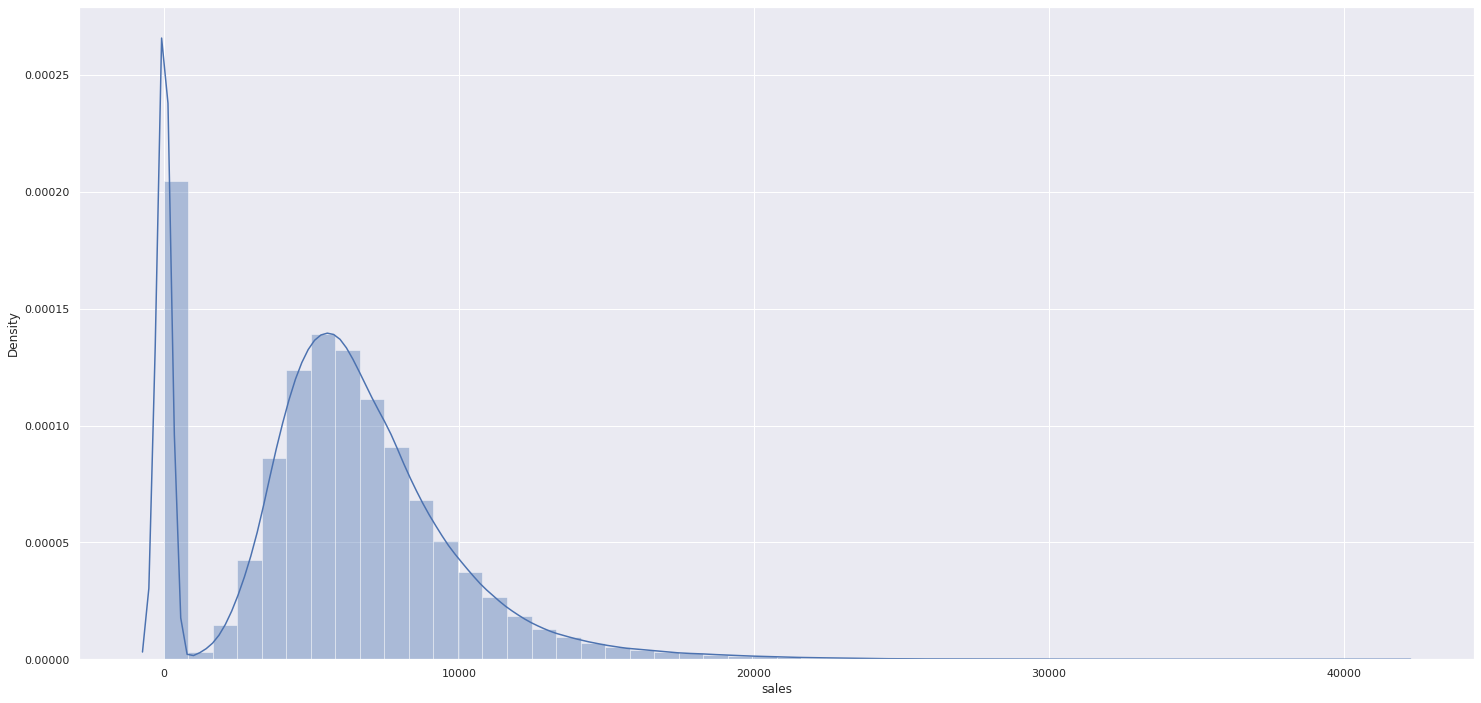

In [20]:
sns.distplot(df1['sales'])

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

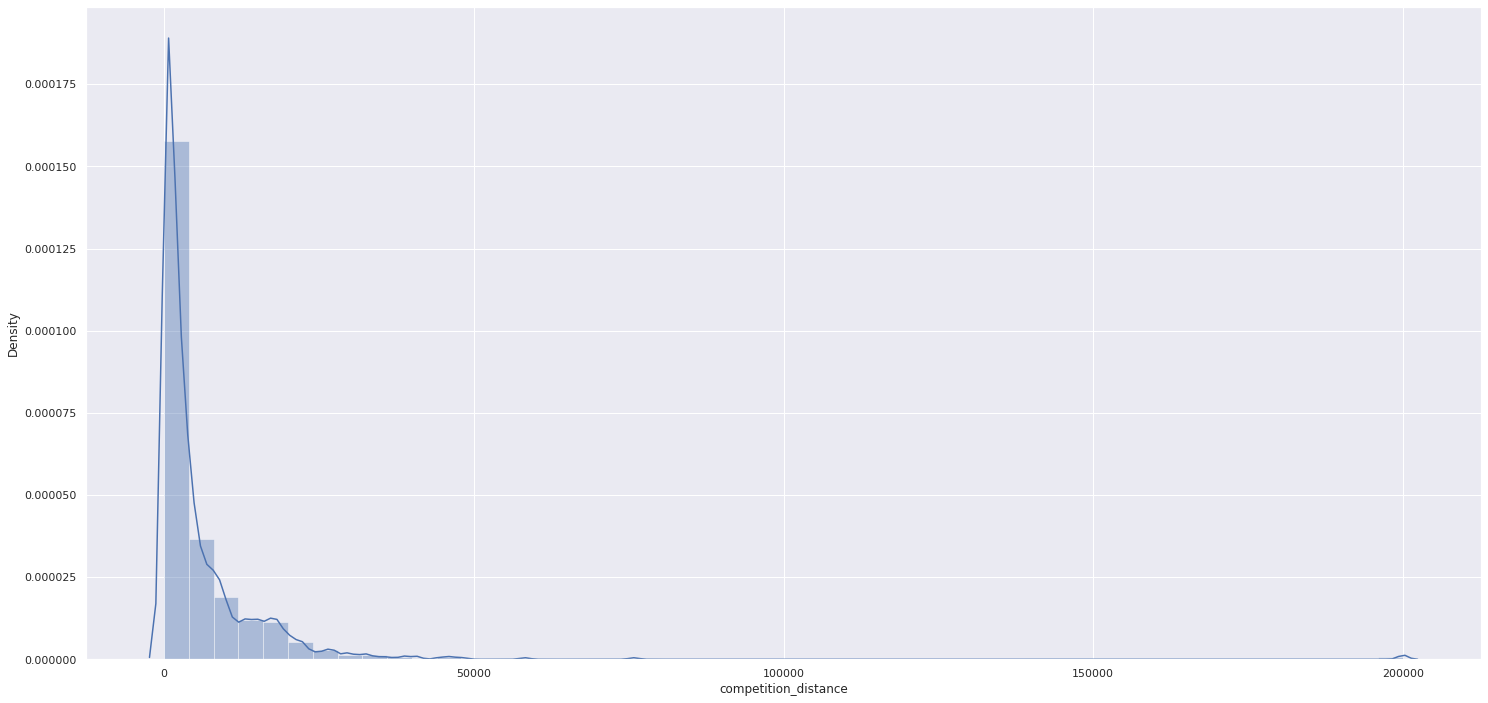

In [21]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

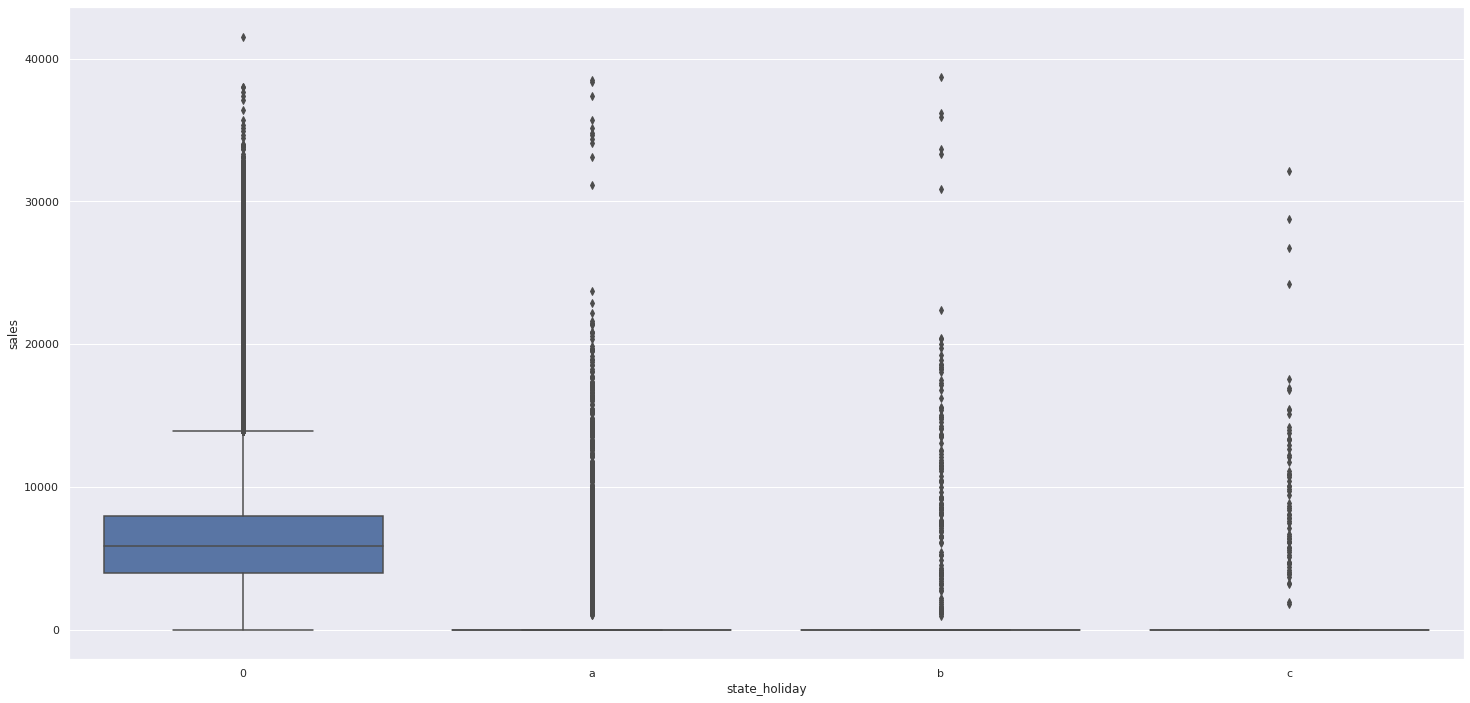

In [23]:
# x =linha que fica como referencia(nome da categoria), y = o que quero medir em cada um dos niveis da variavel categorica 
sns.boxplot(x='state_holiday', y='sales',data=df1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

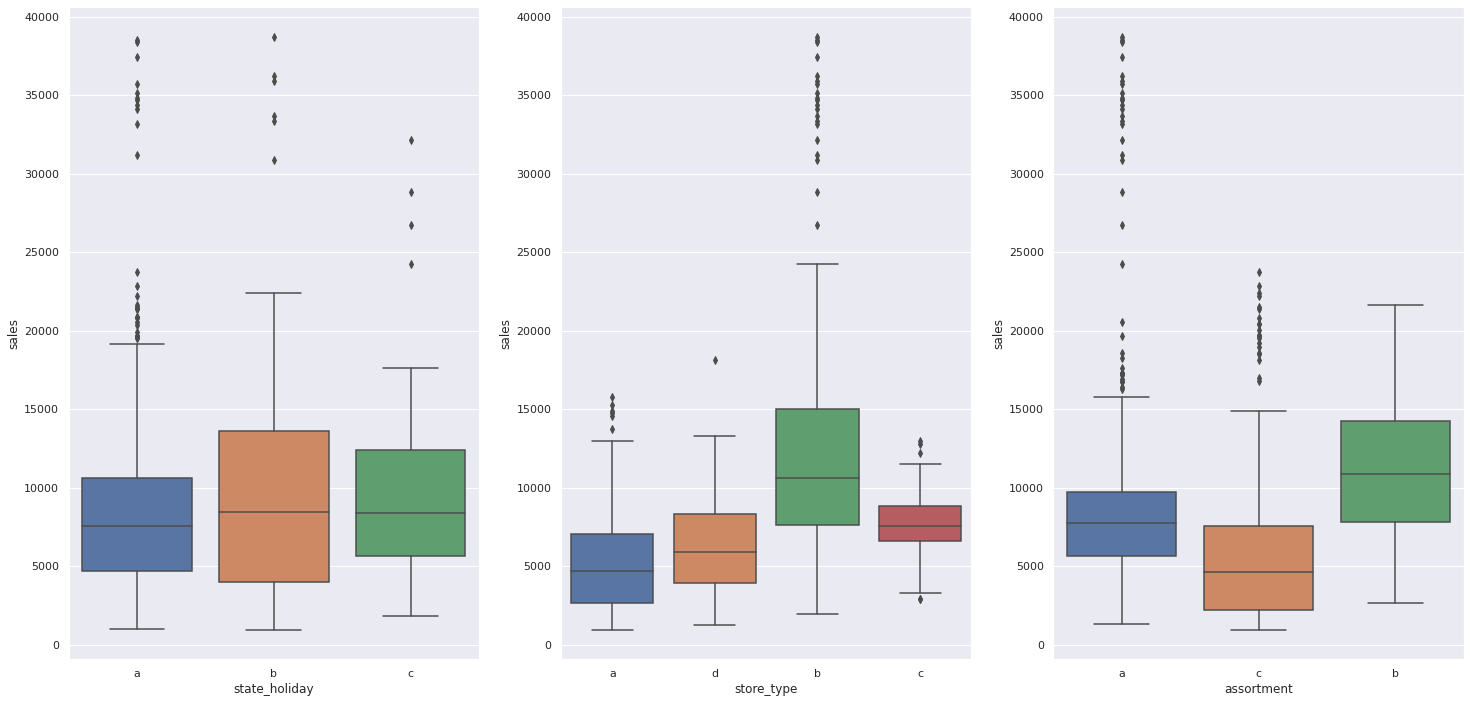

In [24]:
# a imagem acima fica de dificil compreensão por conta que a dimensão das variaveis esta muito diferente ( tem dias que não temvendas por conta das lojas estarem fechadas)
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales',data=aux1)


# 2.0.(Passo 2) FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

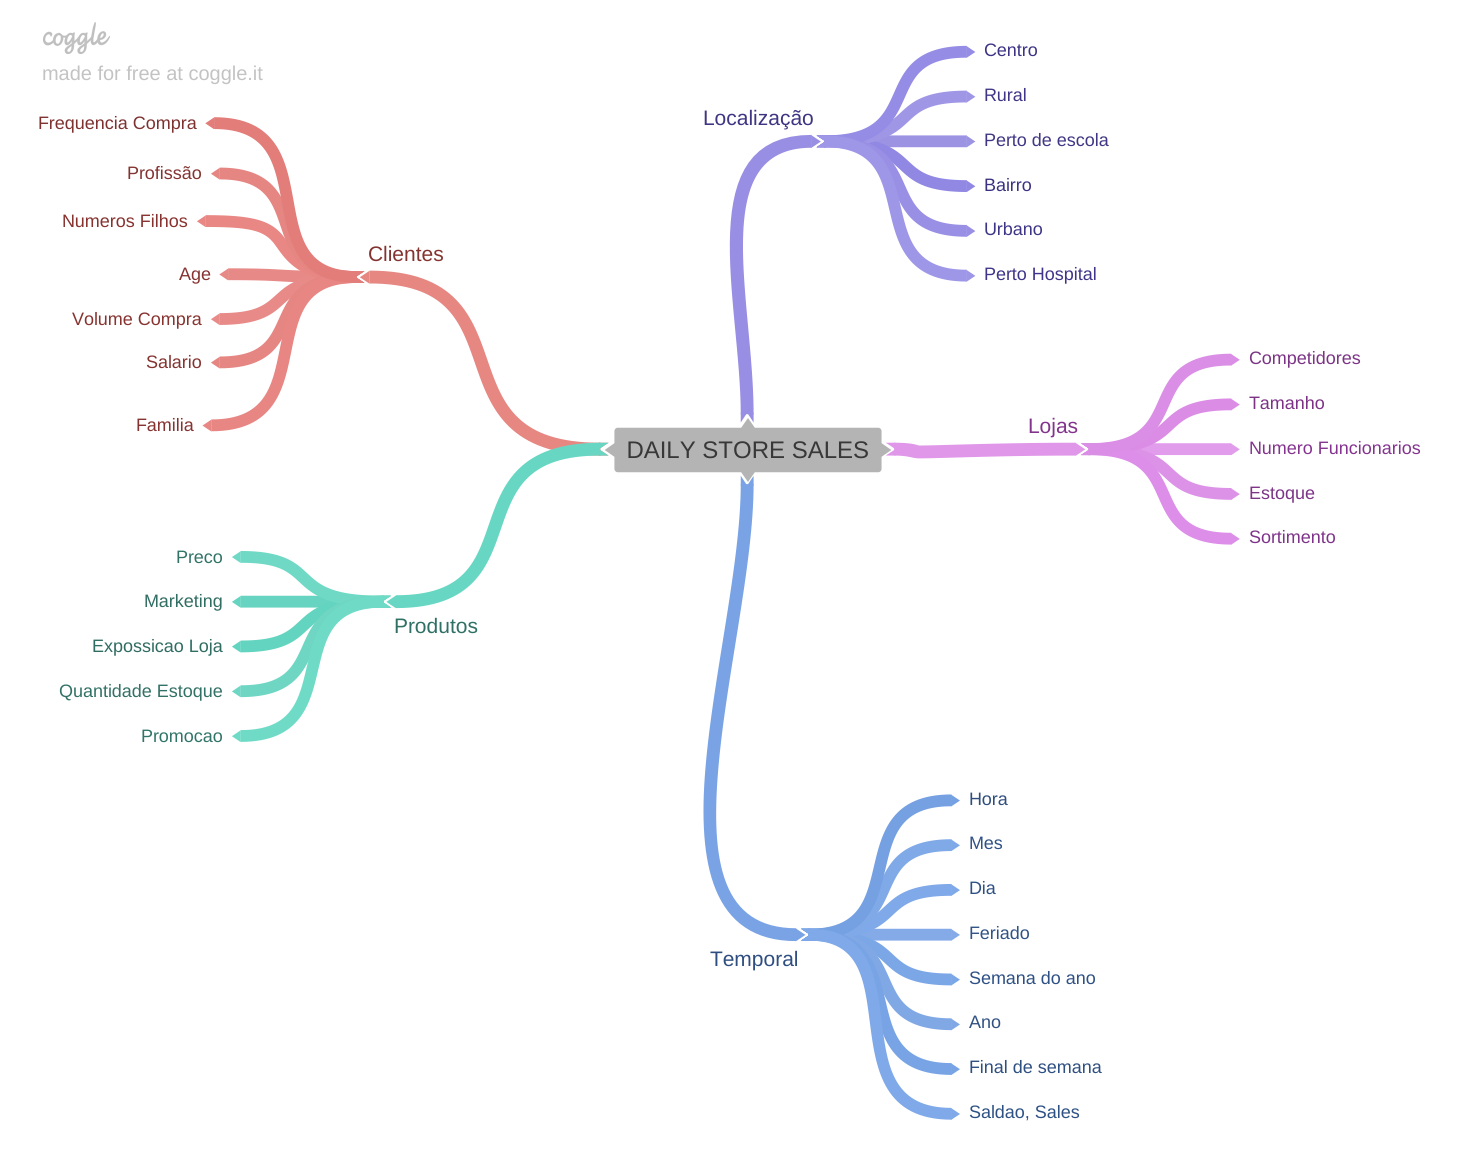

In [26]:
Image('img/MindMapHypothesis.png')

## 2.1. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores á mais tempo deveriam vender menos.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposicao produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem produtos com precos menores deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Lista final de Hipoteses

In [27]:
#Dando prioridade para as que os dados estão disponiveis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores á mais tempo deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [28]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0.(Passo 3) FILTRAGEM DE VARIÁVEIS

In [30]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [31]:
#vou filtrar as colunas que open e sales são diferente de 0, pois isso indica que a loja estava fechada e isso pode impactar a previsão
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1. Selecao de Colunas

In [32]:
# variaveis que não tera valor no monmento da previsão e por esse motivo não irei usar. Open (nesse momento não tera utilidade pois a partir de agora todas as lojas estão abertas)
#customer não terei esse dado no momento da predicao por isso vou excluir
cols_drop=['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop,axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. (Passo 4) ANALISE EXPLORATORIA DOS DADOS


In [34]:
df4 = df3.copy()


## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

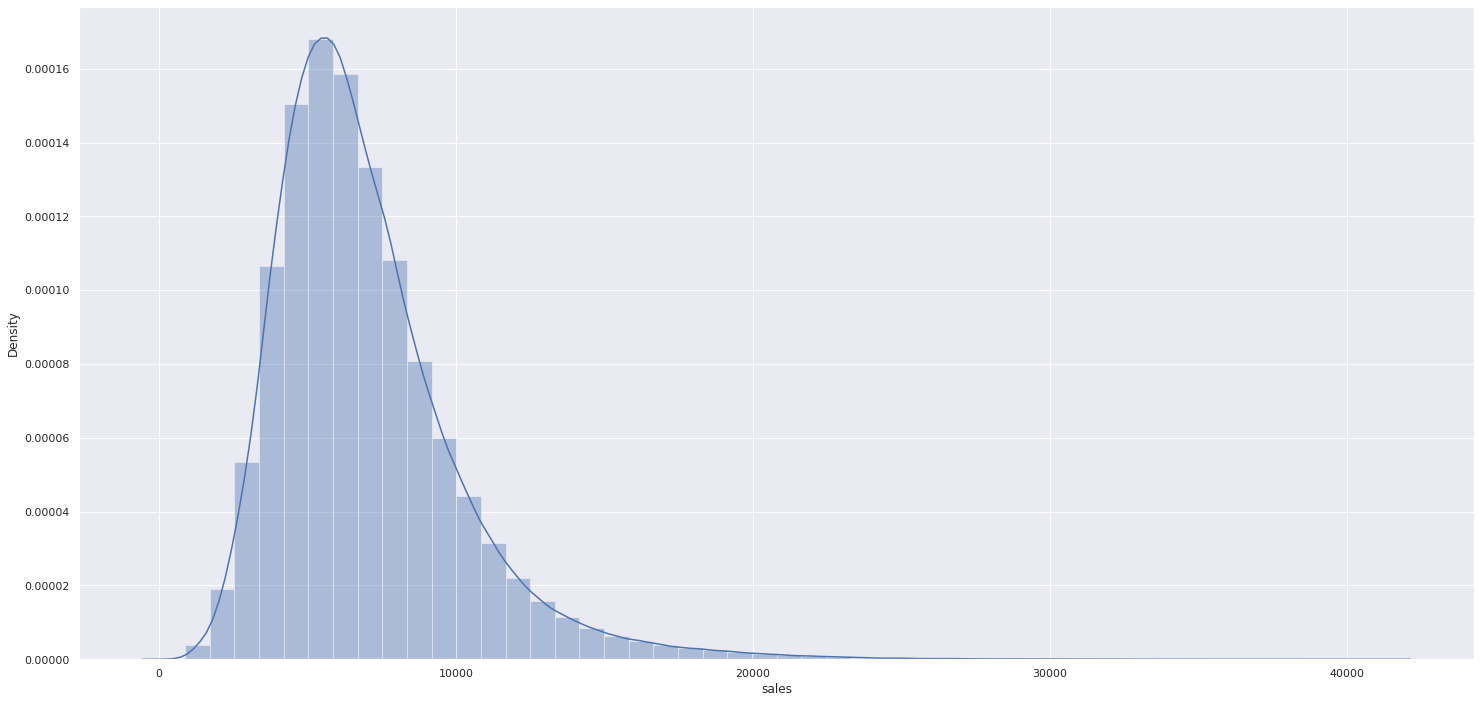

In [35]:
#por que procuramos sempre que a distribuicao seja uma normal, ou parecida com uma? 
#A maioria dos algoritmos de machine learning tem como premissa dados independentes e que sigam a distribuição normal
#existem transformações para se chegar proximo de uma normal como log1p,boxcox,exponencial, etc...
sns.distplot(df4['sales'])
#caso queria tirar a linha em volta do histograma
#sns.distplot(df4['sales'],kde= False)

### 4.1.2. Numerical Variable

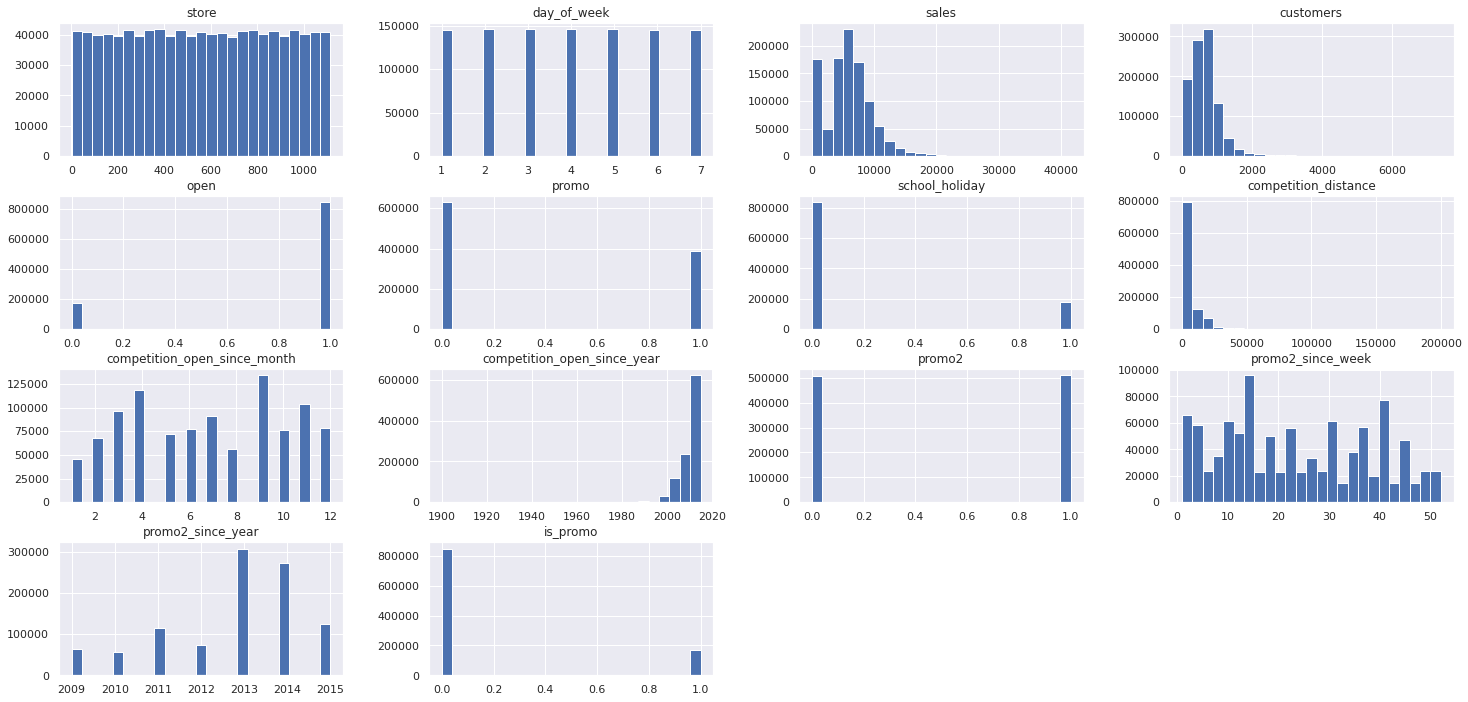

In [36]:
#histograma das variaveis numericas
#bins é cada retangulo
num_attributes.hist(bins =25);

### 4.1.3. Categorical Variable

In [37]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

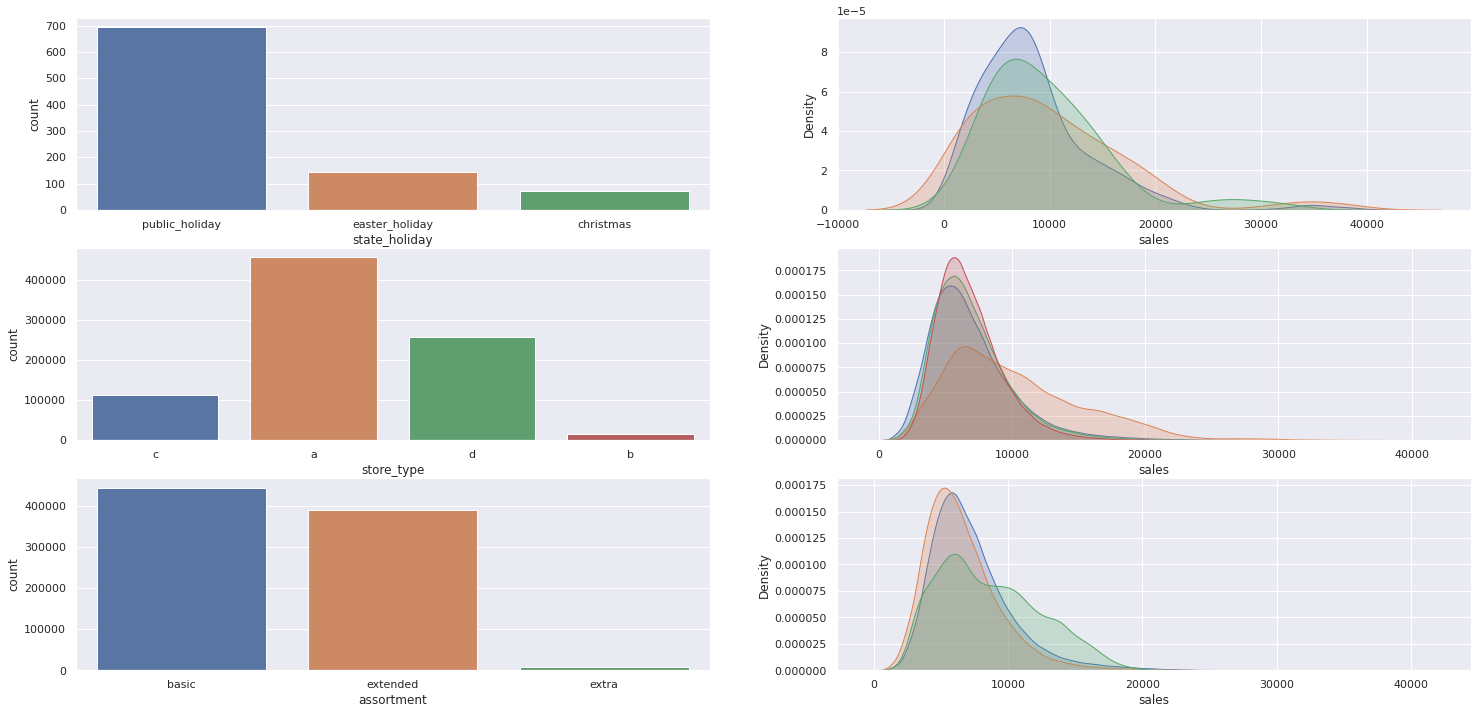

In [38]:
# state_holiday
#exclui regular day pois é a maioria e deixava as outras variaveis parecendo que tinha 0
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'],label='public_holiday',shade=True)
#store_type
plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] =='a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] =='b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] =='c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] =='d']['sales'],label='d',shade=True)
#assortment
plt.subplot(3,2,5)

sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] =='extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'],label='extra',shade=True)


## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.



<AxesSubplot:xlabel='assortment', ylabel='sales'>

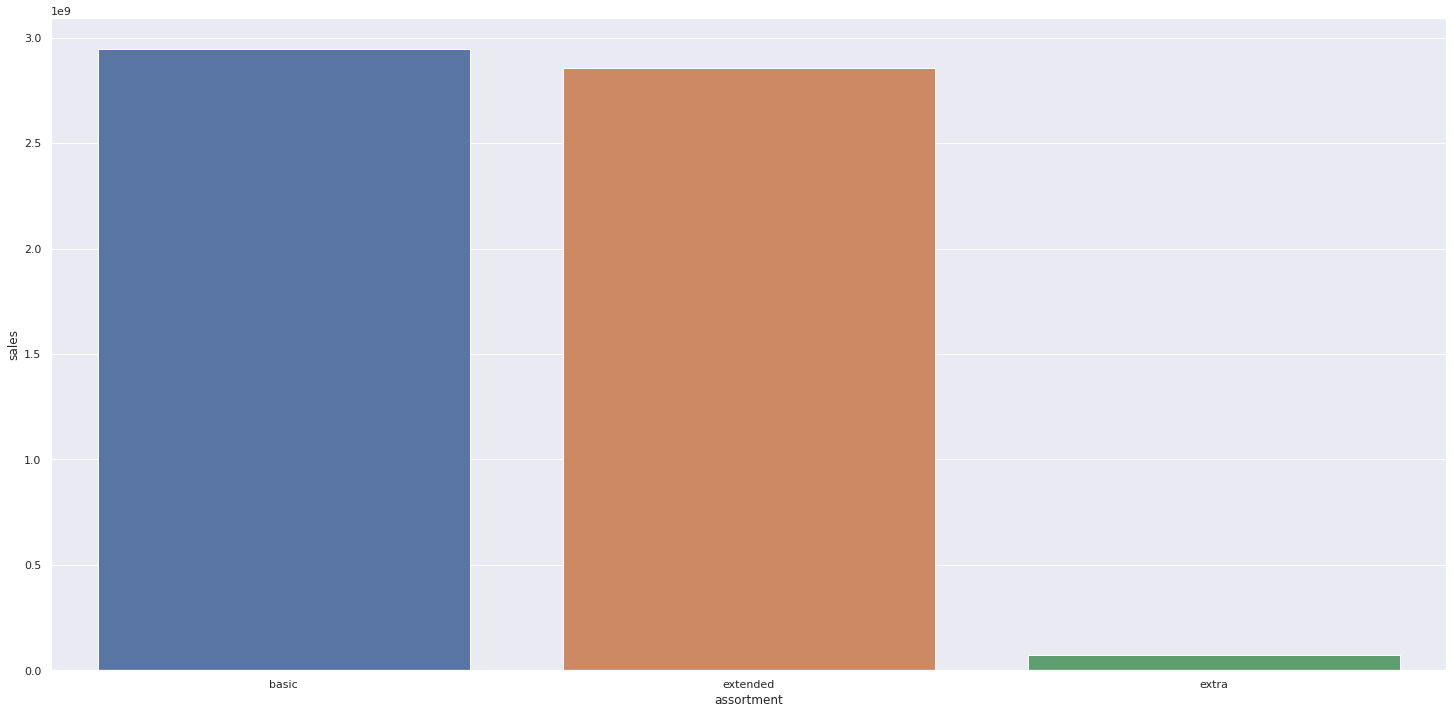

In [39]:
#vamos assumir que o assortment extra significa maior
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment' , y='sales', data=aux1)

<AxesSubplot:xlabel='year_week'>

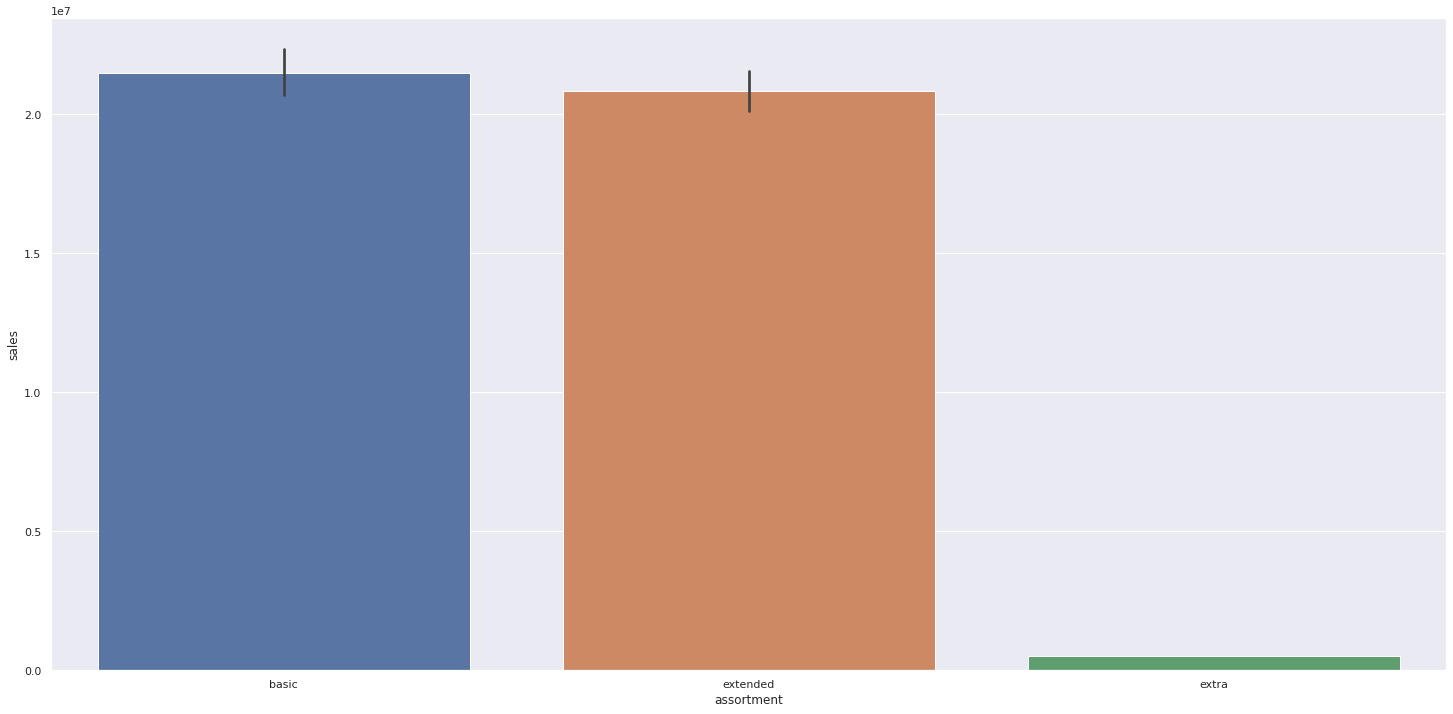

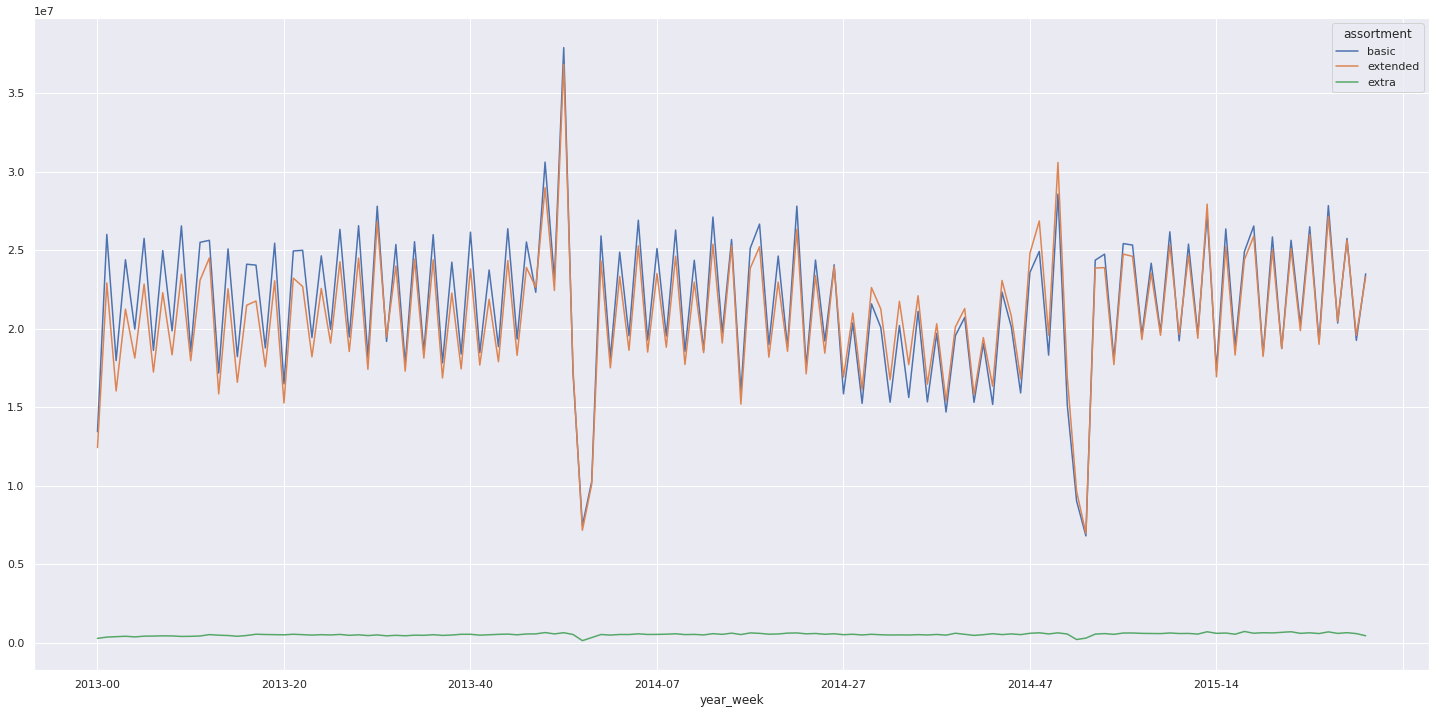

In [40]:
# verificando se o extra foi maior em algum periodo do tempo
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
sns.barplot(x = 'assortment' , y='sales', data=aux2)
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()


In [41]:
# de acordo com os graficos acima pode - se perceber que o volume de venda do basic e extends são praticamente o mesmo(mesmo comportamento) , 
#o volume de extends e basica esta levando a escala muito alto, precisa analisar o extra separadamente para ver o comportamento

<AxesSubplot:xlabel='year_week'>

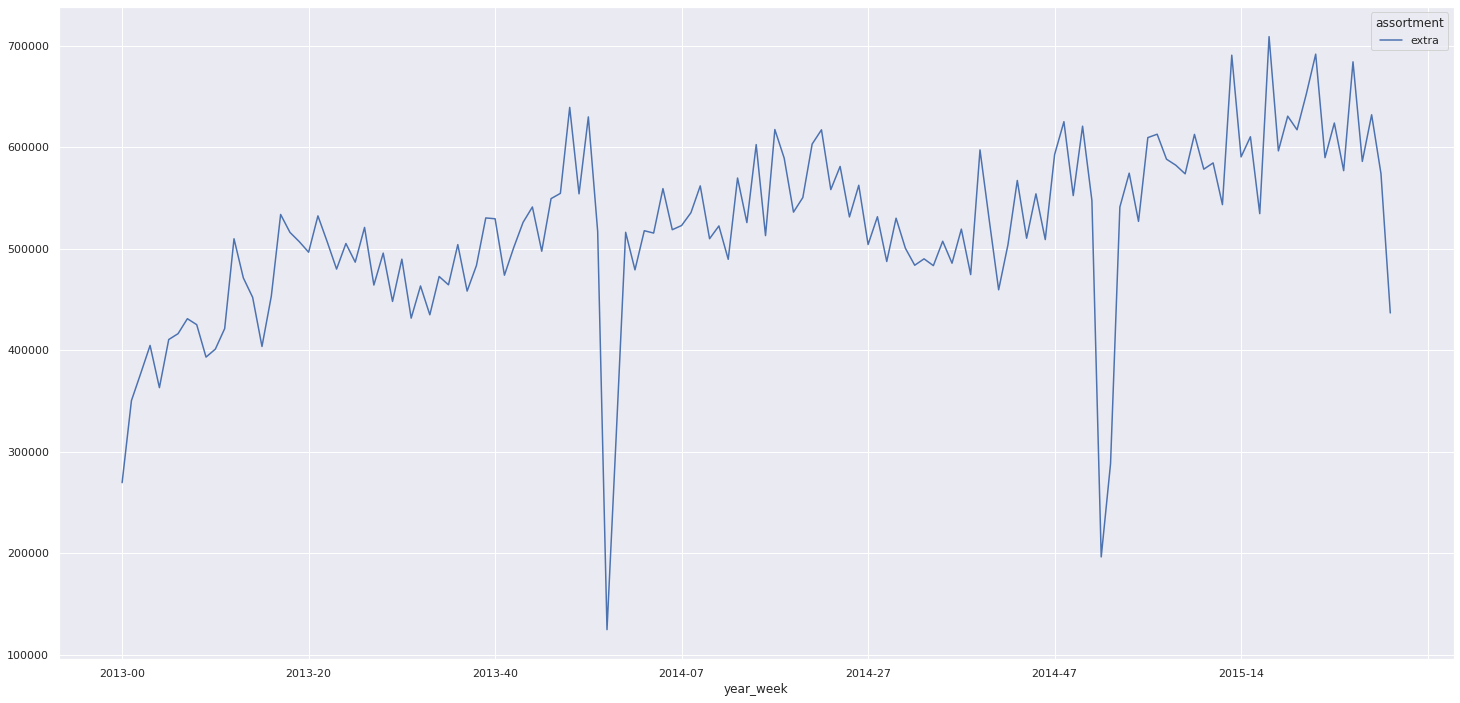

In [42]:
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment',values='sales').plot()

In [43]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas com maior sortmento vendem MENOS
# a variavel será relevante para o modelo pois o assortment extra não segue o padrão das demais.

### **H2.** Lojas com competidores mais proximos deveriam vender menos.


<AxesSubplot:>

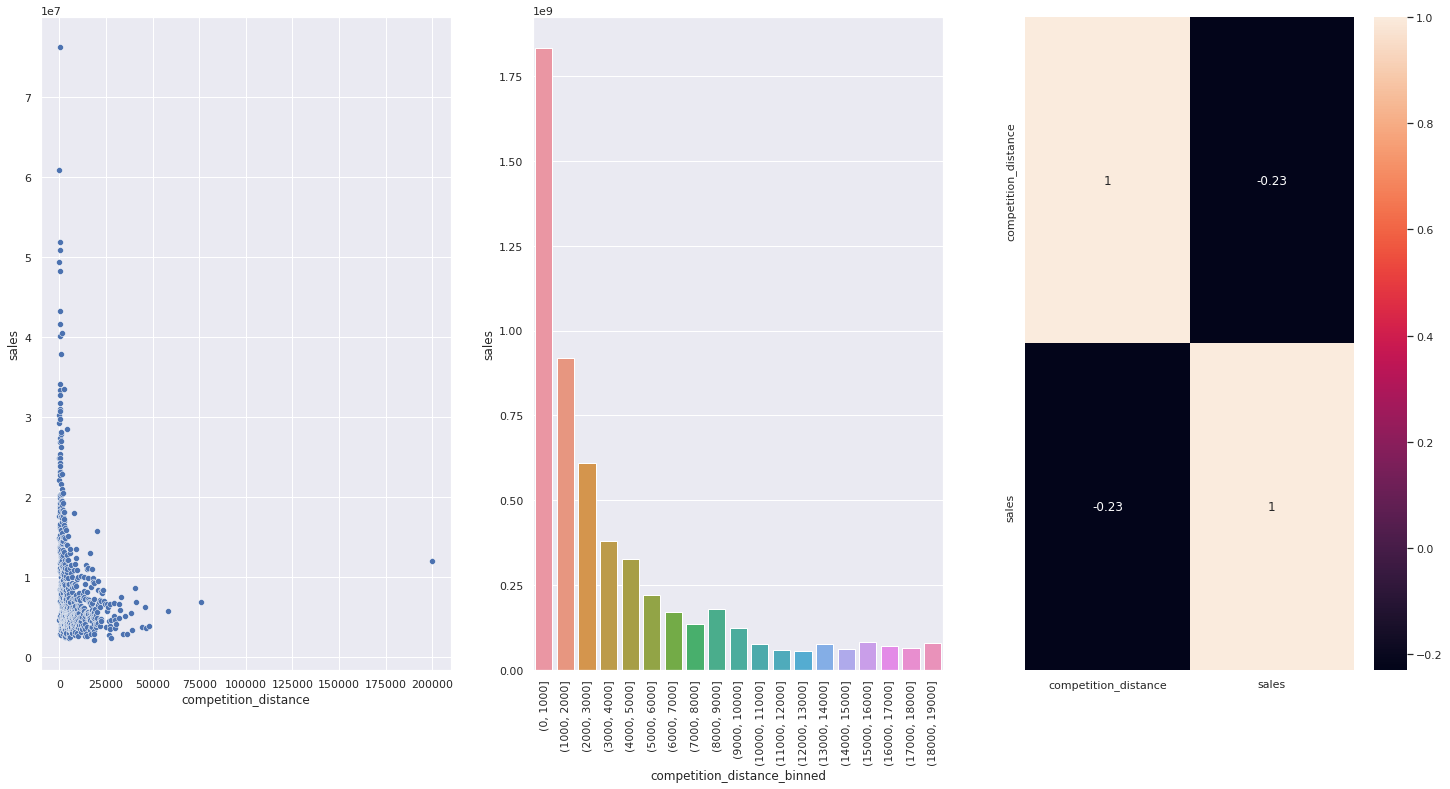

In [44]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
#scatterplot
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
#criando bins pra não poluir o plot
bins = list (np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned',y ='sales',data = aux2 );
plt.xticks(rotation=90)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


In [45]:
#RESULTADO: FALSE
# Lojas com competidores mais PROXIMOS vendem MAIS
# A correlação mostra que quanto mais distante meu concorrente está, menor a venda.

### **H3.** Lojas com competidores á mais tempo deveriam vender menos.

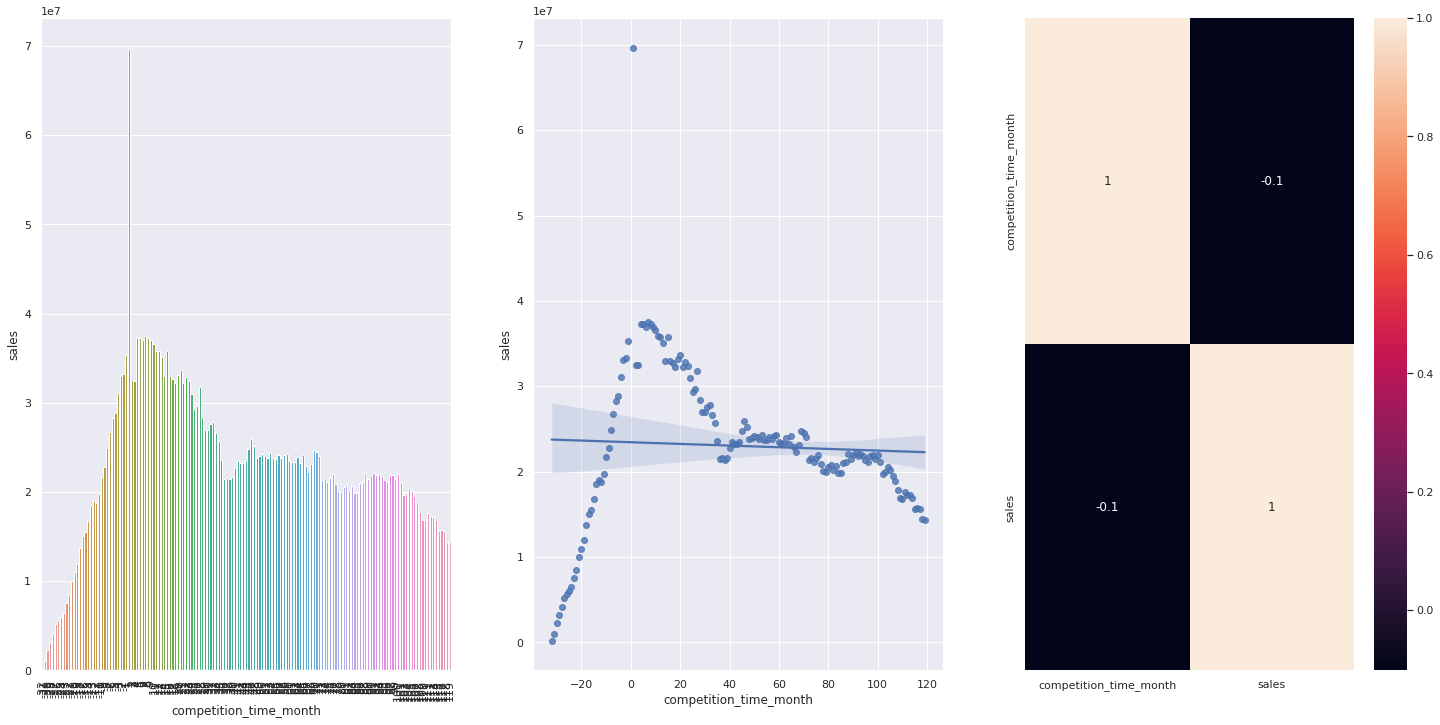

In [46]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data=aux2)
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data=aux2);

plt.subplot(1,3,3)
x =sns.heatmap(aux1.corr(method='pearson'),annot=True);


In [47]:
#explicacao do grafico 1
#competition_time_month = valor da venda agora(date) - data que o competidor abriu
#valores negativos: quando o competidor ainda não abriu(ex: ele abrirá daqui a 4 meses)
#valores positivos: venda maior (ex: se o competidor abriu 6 meses atrás)
#quanto mais aproxima de 0 maior a venda. Ou seja competições recentes são beneficas para o aumento das vendas 

#explicacao da correlacao
# e uma boa correlacao nao proxima de 0 que seria algo em torno de 0.0..., porém longe de -1 ou 1

In [48]:
# RESULTADO: FALSE

#Lojas com COMPETIDORES a MAIS TEMPO vendem  MENOS

### **H4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.


In [49]:
df4.head()
#existe 2 periodos promocionais - o tradicional e o extendido. se for negativo , a compra foi feita na promocao tradicional, caso seja positivo foi no periodo da promo2(extendida)
#a promo2 é opcional para a loja

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


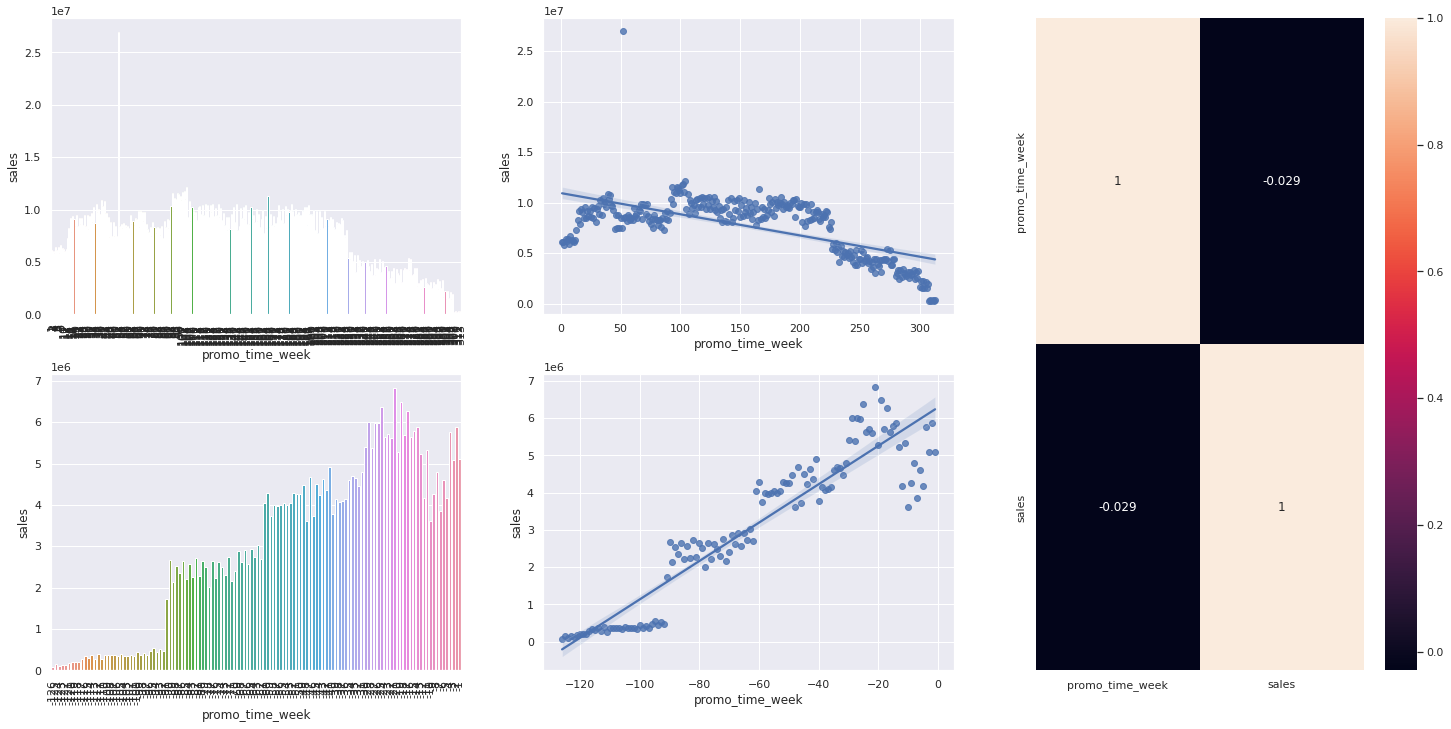

In [50]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid =GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']> 0] # periodo extendido
sns.barplot(x = 'promo_time_week' , y='sales', data=aux2);
plt.xticks(rotation = 90);

#grafico de tendencia
plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week' , y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']< 0] # periodo regular
sns.barplot(x = 'promo_time_week' , y='sales', data=aux3);
plt.xticks(rotation = 90);

#grafico de tendencia
plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week' , y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot= True);

In [51]:
# a variavel é relevante para o modelo?
# tem um comportamento relevante, pois é possivel ver que no periodo promocional as vendas se mantem constantes ate um certo ponto
# e no periodo regular nota-se um atraso até que as vendas crescam, tlvz influenciado por alguma ação de marketing?

In [52]:
# RESPOSTA: FALSA
# Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao
# a correlacao se mostrou fraquissima.Mostra-se a principio irrelevante para o modelo. Porém pode ser que combinada com outra variavel produza algum efeito, a ser validado mais adiante.

### **H5.** Lojas com mais dias de promocao deveriam vender mais.


In [53]:
#hipotese parecida com a anterior. Deverá ser abordada no proximo ciclo do crisp

### **H6.** Lojas com mais promocoes consecutivas deveriam vender mais.

In [54]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


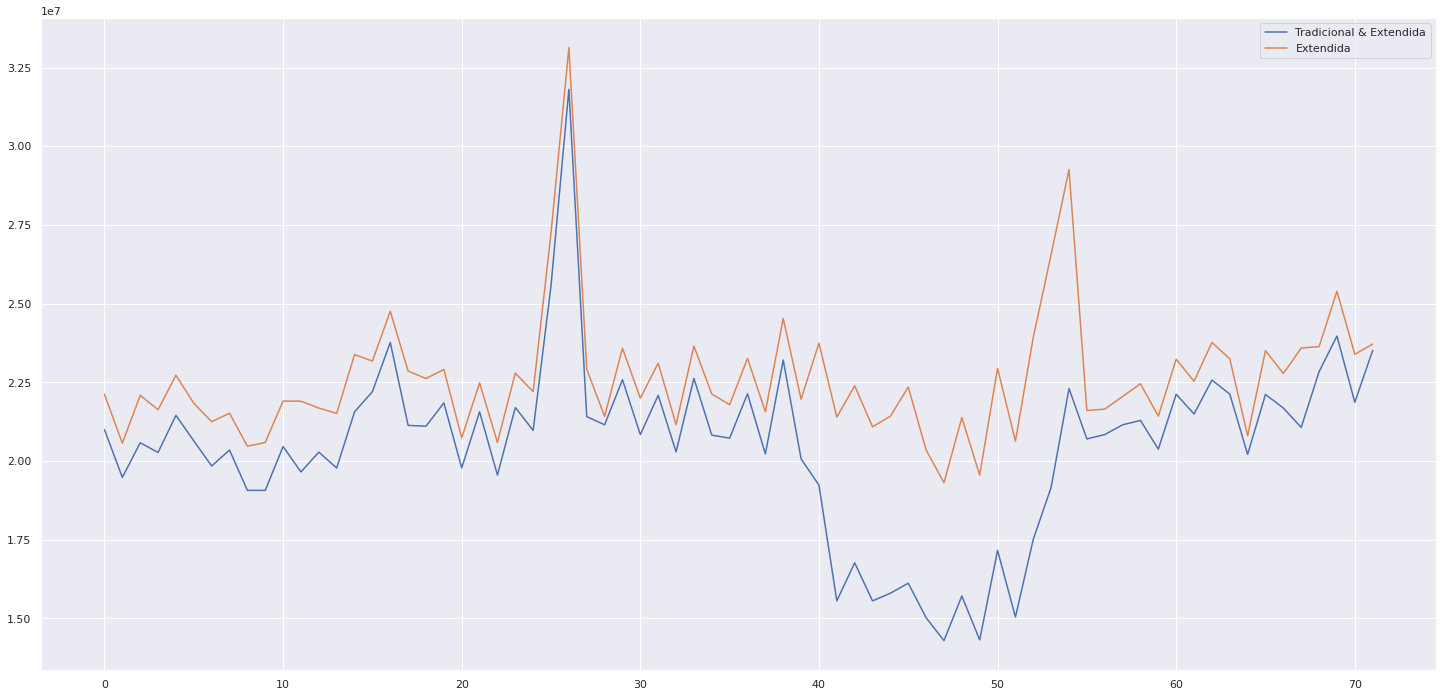

In [55]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

In [56]:
# lojas com promoções consecutivas não vendem mais(linha azul)
# basicamente o comportamento é o mesmo das curvas, apenas em um momento que isso nao é observado. 
#Em linhas gerais, não influencia o modelo. Deve-se ver se em conjunto com outra variavel ela se torna relevante

In [57]:
#RESPOSTA: FALSA
#Lojas com promoções consecutivas vendem menos

## 4.3. Analise Multivariada



### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.


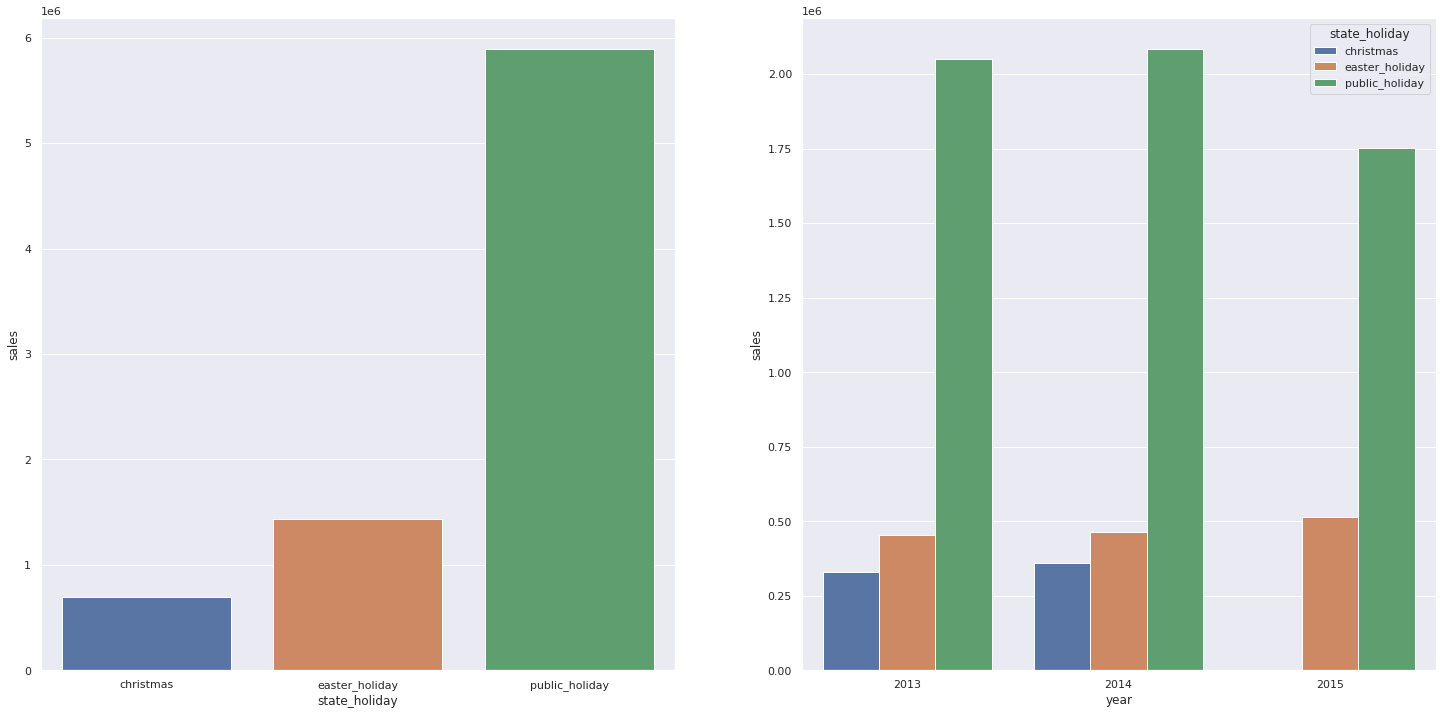

In [58]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday' ,y ='sales', data = aux1);

plt.subplot(1,2,2)
#vendo se natal ja vendeu mais que os outros feriados
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
#hue = tipos de barras ( para cada state_holiday quero uma barra)
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

In [59]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas abertas durante o feriado do natal vendem menos

### **H8.** Lojas deveriam vender mais ao longo dos anos.

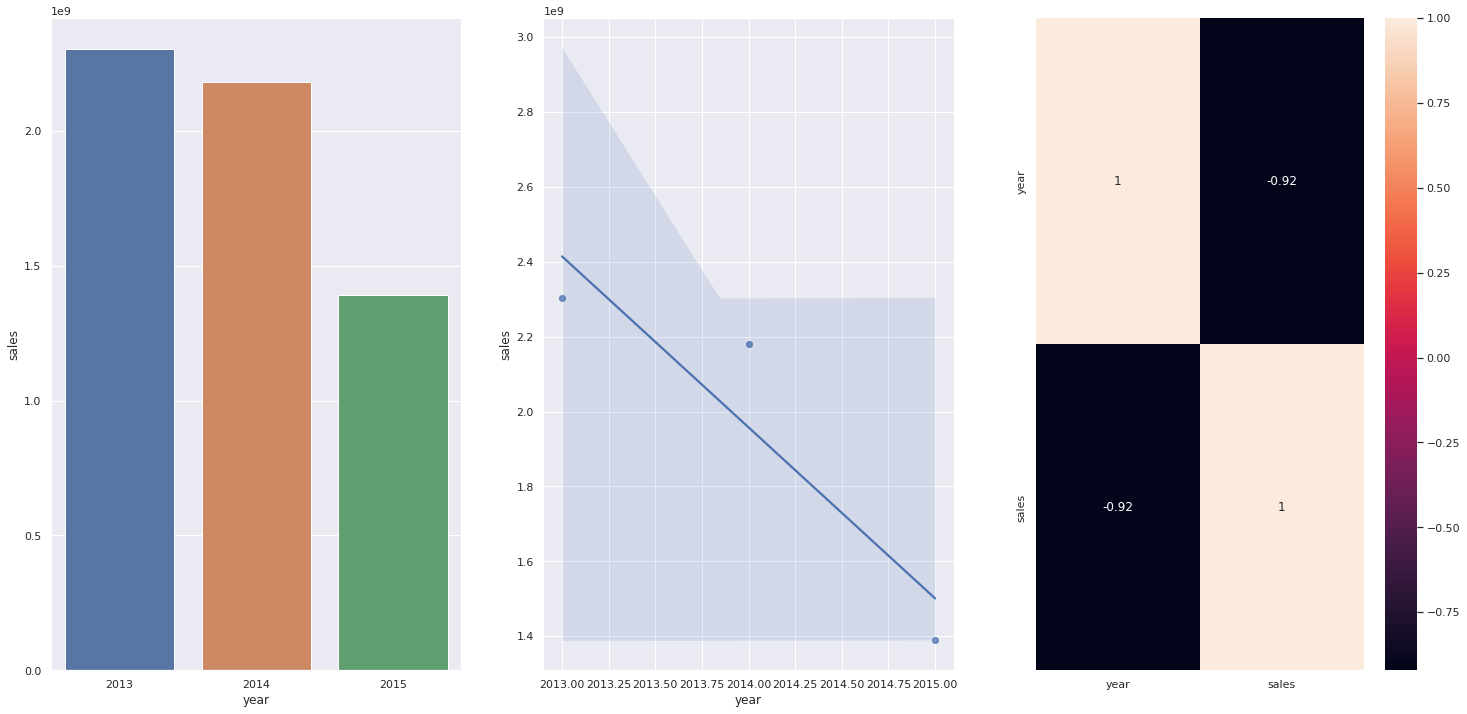

In [60]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y ='sales', data = aux1);

plt.subplot(1,3,2)
#tendencia
sns.regplot(x = 'year', y ='sales', data = aux1);

plt.subplot(1,3,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);

In [61]:
# correlacao muito forte negativamente - Conforme os anos passam as vendas caem. (2015 não é um ano completo, pode interferir...)
#é um indicio que ano é importante para o modelo

In [62]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas  vendem menos ao longo dos anos

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.


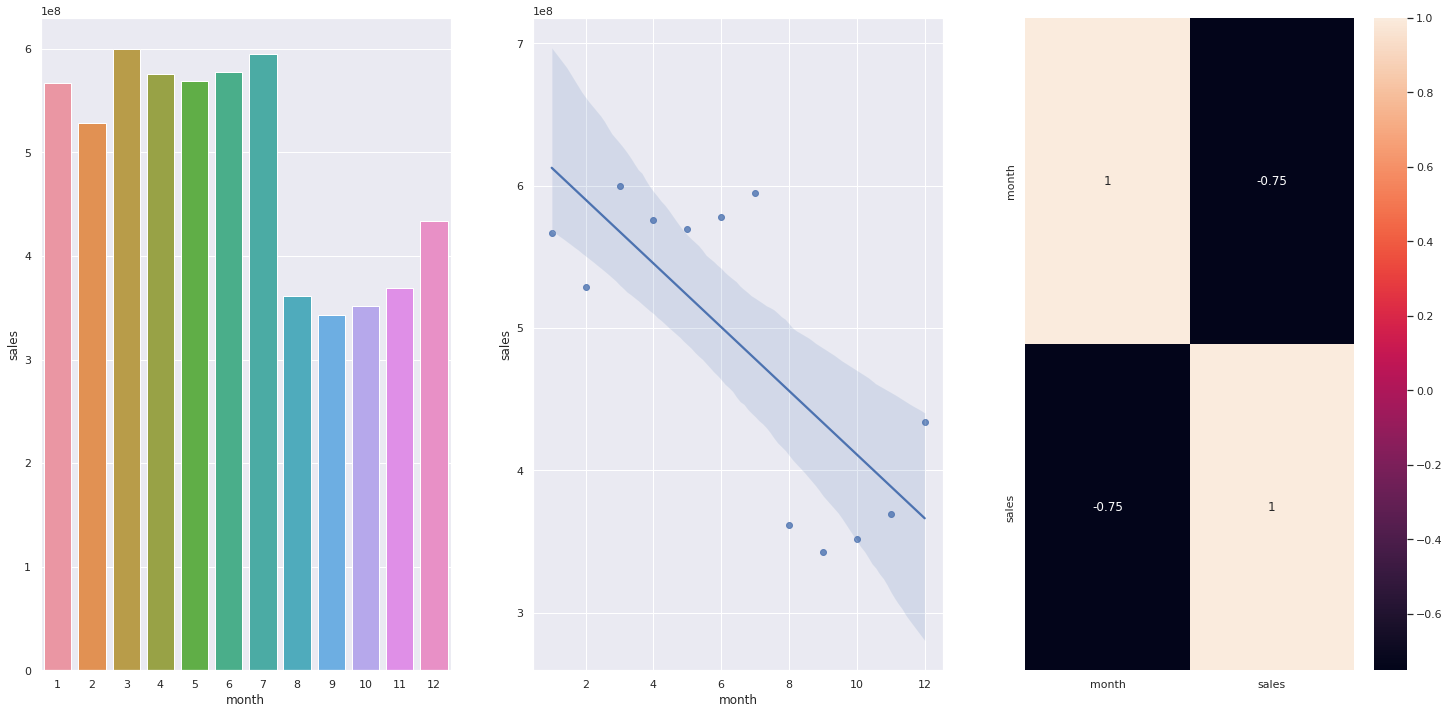

In [63]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y ='sales', data = aux1);

plt.subplot(1,3,2)
#tendencia
sns.regplot(x = 'month', y ='sales', data = aux1);

plt.subplot(1,3,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);

In [64]:
# as lojas vendem menos no segundo semestre
#importante para o modelo

In [65]:
# RESPOSTA DA HIPÓTESE: FALSA
# Lojas  vendem menos no segundo semestre do ano

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

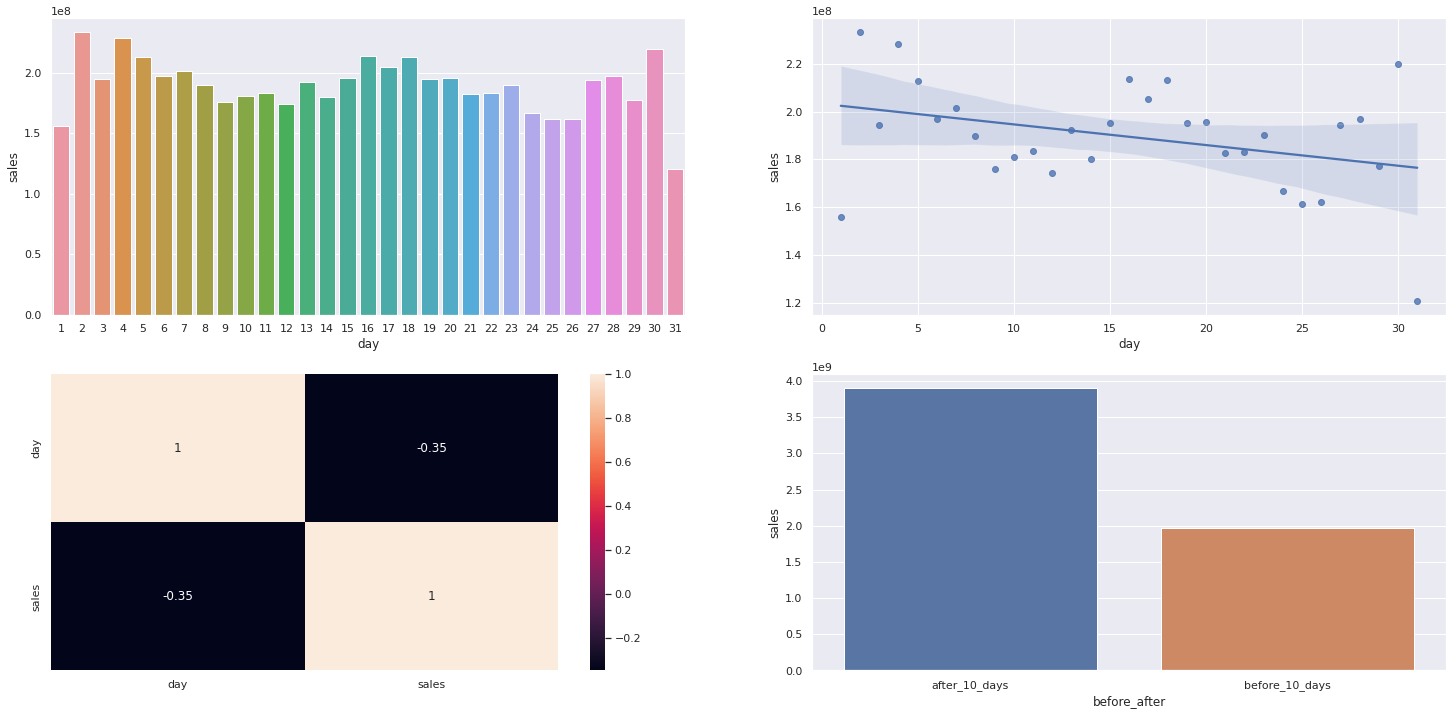

In [66]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y ='sales', data = aux1);

plt.subplot(2,2,2)
#tendencia
sns.regplot(x = 'day', y ='sales', data = aux1);

plt.subplot(2,2,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales', data=aux2);

In [67]:
# RESPOSTA DA HIPÓTESE: TRUE
# Lojas  vendem mais depois do dia 10

### **H11.** Lojas deveriam vender menos nos finais de semana.

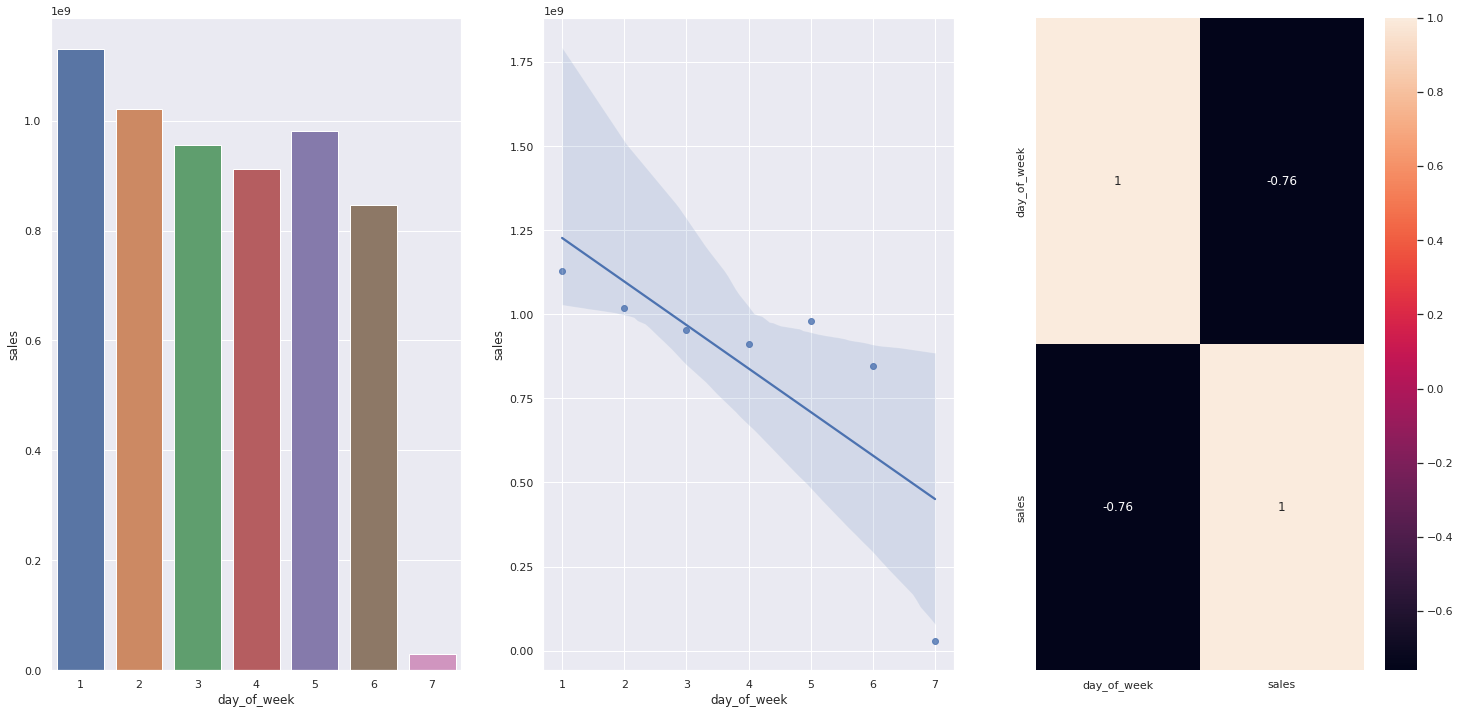

In [68]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y ='sales', data = aux1);

plt.subplot(1,3,2)
#tendencia
sns.regplot(x = 'day_of_week', y ='sales', data = aux1);

plt.subplot(1,3,3)
#correlacao
sns.heatmap(aux1.corr( method='pearson'),annot =True);



In [69]:
# RESPOSTA DA HIPÓTESE: TRUE
# Lojas  vendem menos nos finais de semana

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

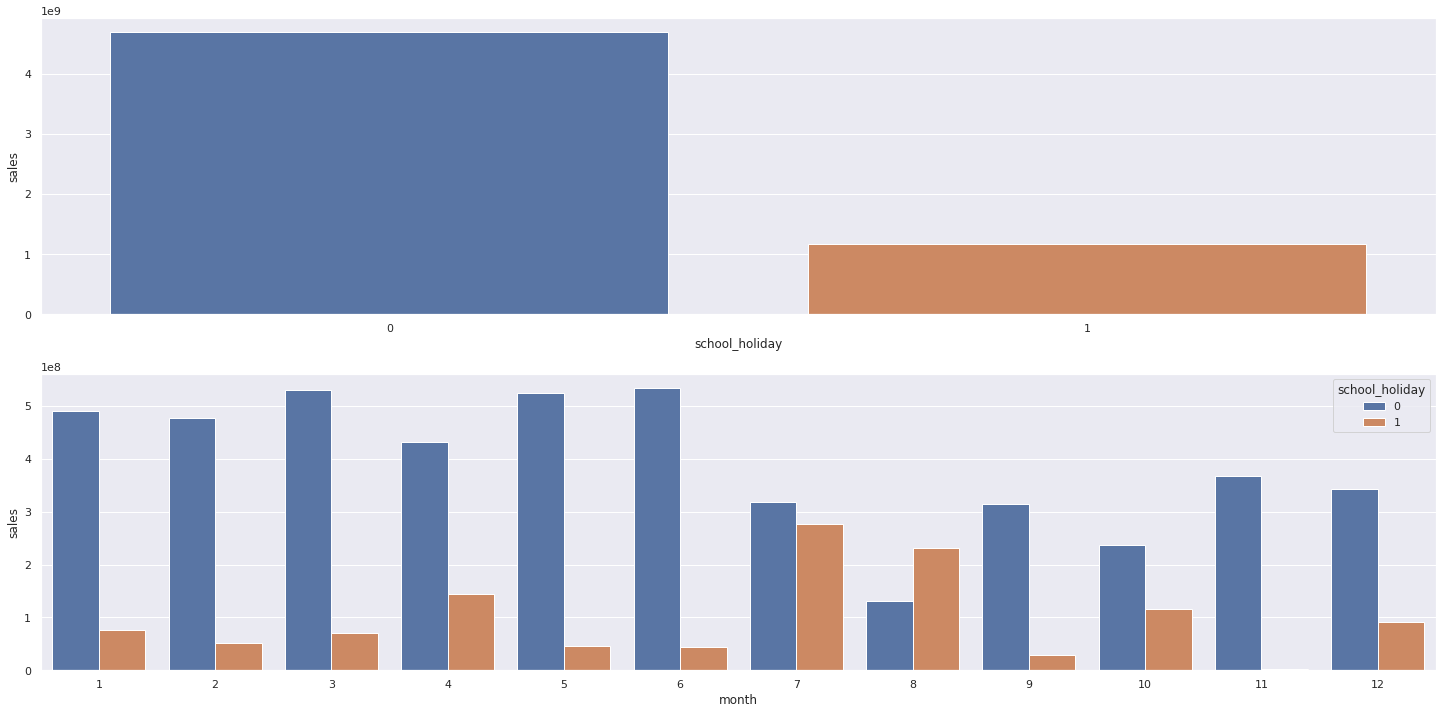

In [70]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y ='sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y ='sales', hue = 'school_holiday', data = aux2);

In [71]:
# RESPOSTA DA HIPÓTESE: TRUE
# Lojas  vendem menos nos feriados escolares exceto os meses de Julho e Agosto

### 4.3.1 Numerical Atributes

<AxesSubplot:>

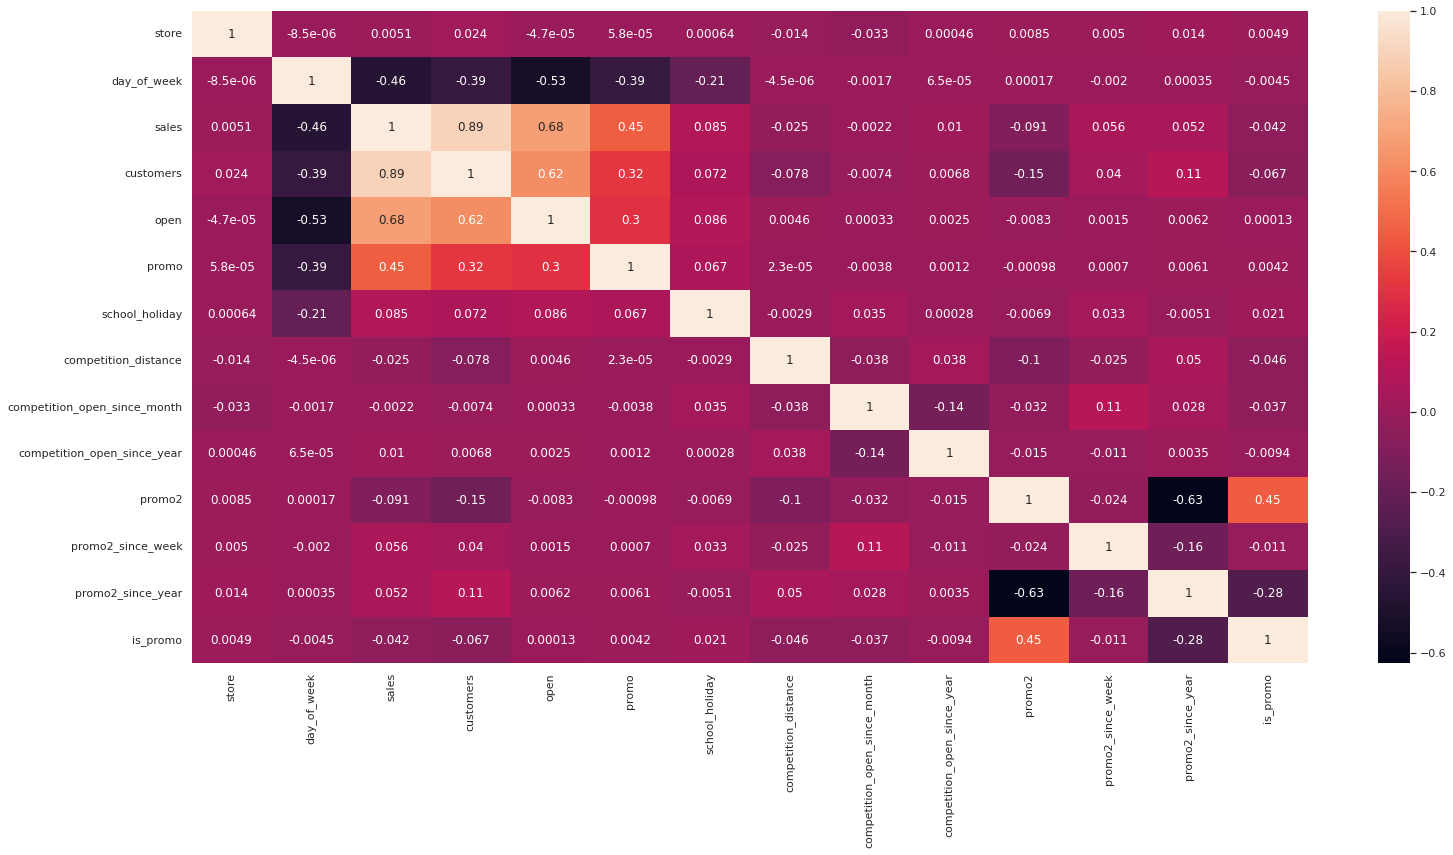

In [72]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation,annot = True)

### 4.3.2 Categorical Atributes

In [73]:
# correlação entre duas variaveis categoricas não se usa pearson e sim cramer V

In [74]:
# only categorical data
a = df4.select_dtypes(include = 'object')

In [75]:
a.head()
#year_week esta como objeto mas é data, então será excluido
# em python tem que implementar a formula na mão . Em R tem pronta

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [76]:
#matrix de confusao
cm = pd.crosstab( a['state_holiday'], a['store_type']).values

In [77]:
#calculate Cramer v 
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final Dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9],           
                })
d = d.set_index(d.columns)

<AxesSubplot:>

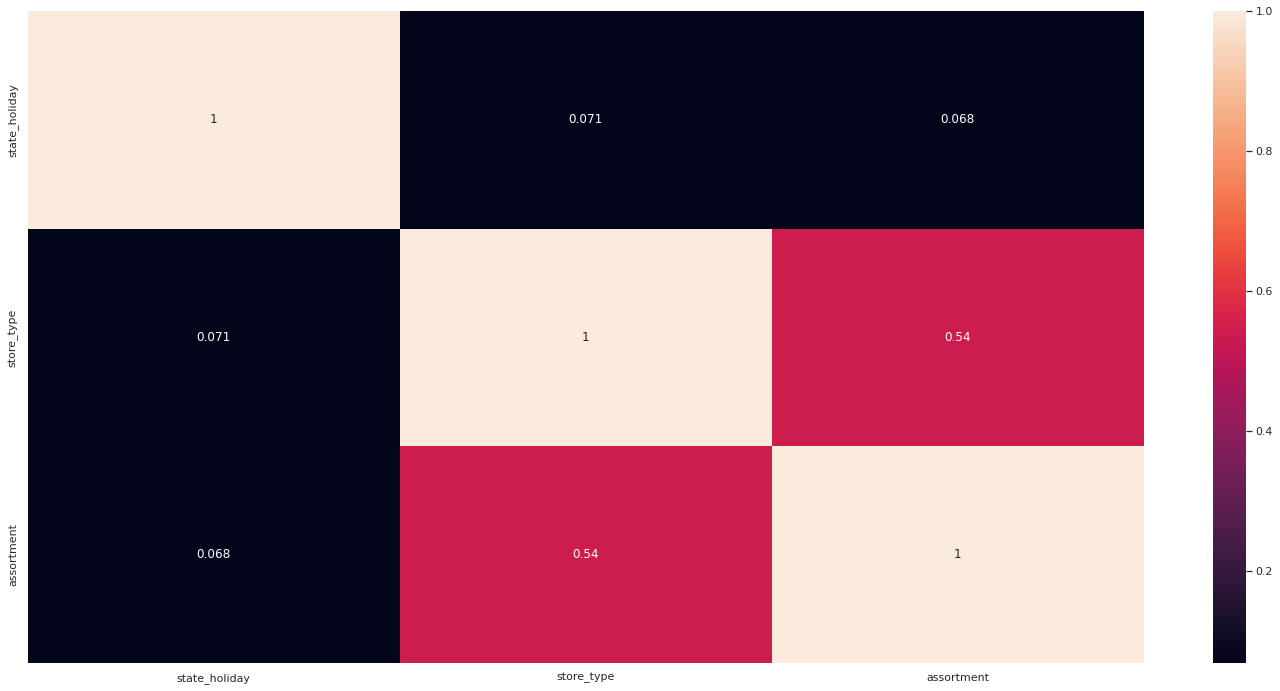

In [78]:
sns.heatmap(d,annot = True)


# 5.0. (Passo 5) DATA PREPARATION

In [79]:
df5 = df4.copy()

## 5.1 Normalizacao

In [80]:
# para ver quais variaveis serão normalizadas, devemos ver a normal das variaveis. Como ja foi feito na secao 4.1.2 nao precisa fazer novamente. 
#Lá vemos que nenhuma variavel segue a distribuicao normal. Portanto ese passo nao sera feito

## 5.2 Rescaling


In [81]:
a = df5.select_dtypes(include =['int64','float64'])

<AxesSubplot:xlabel='competition_distance'>

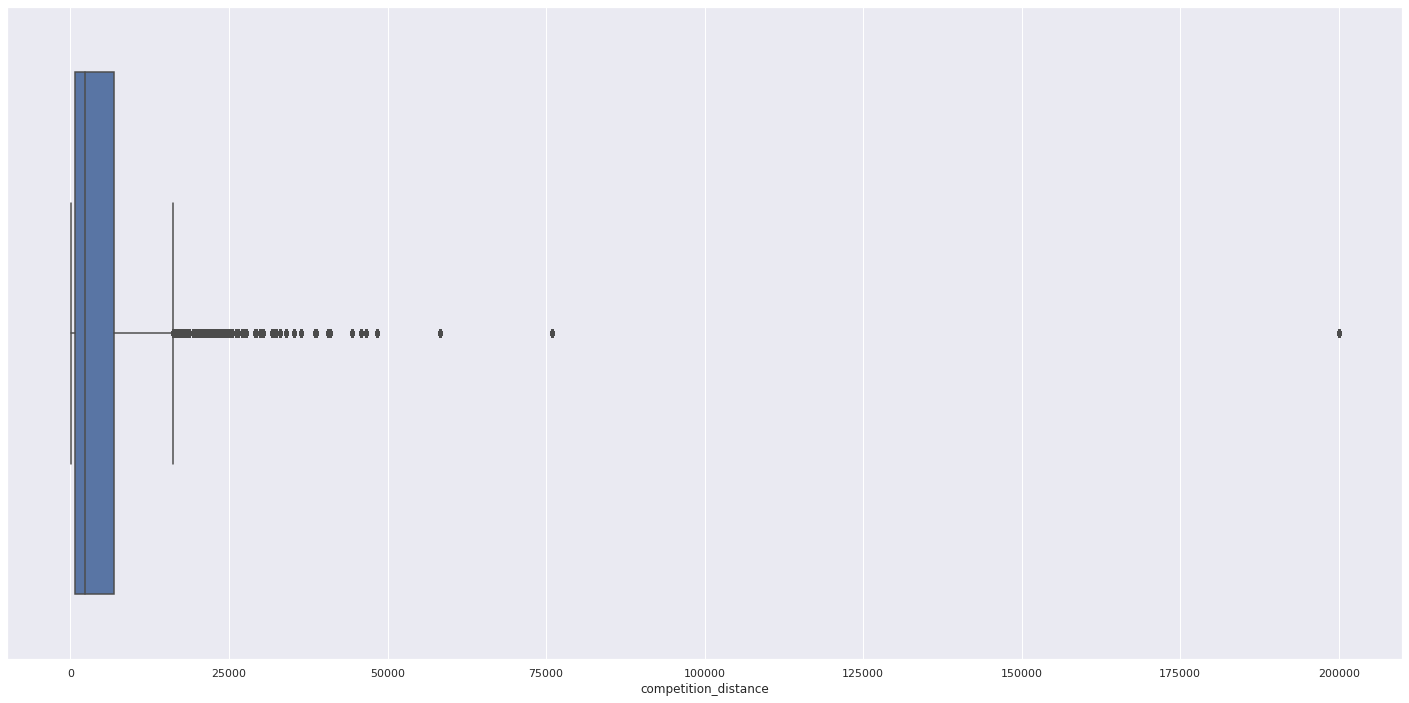

In [82]:
#outliers bem definidos em competition_distance - usar robust scaler
sns.boxplot(df5['competition_distance'])

<AxesSubplot:xlabel='competition_time_month'>

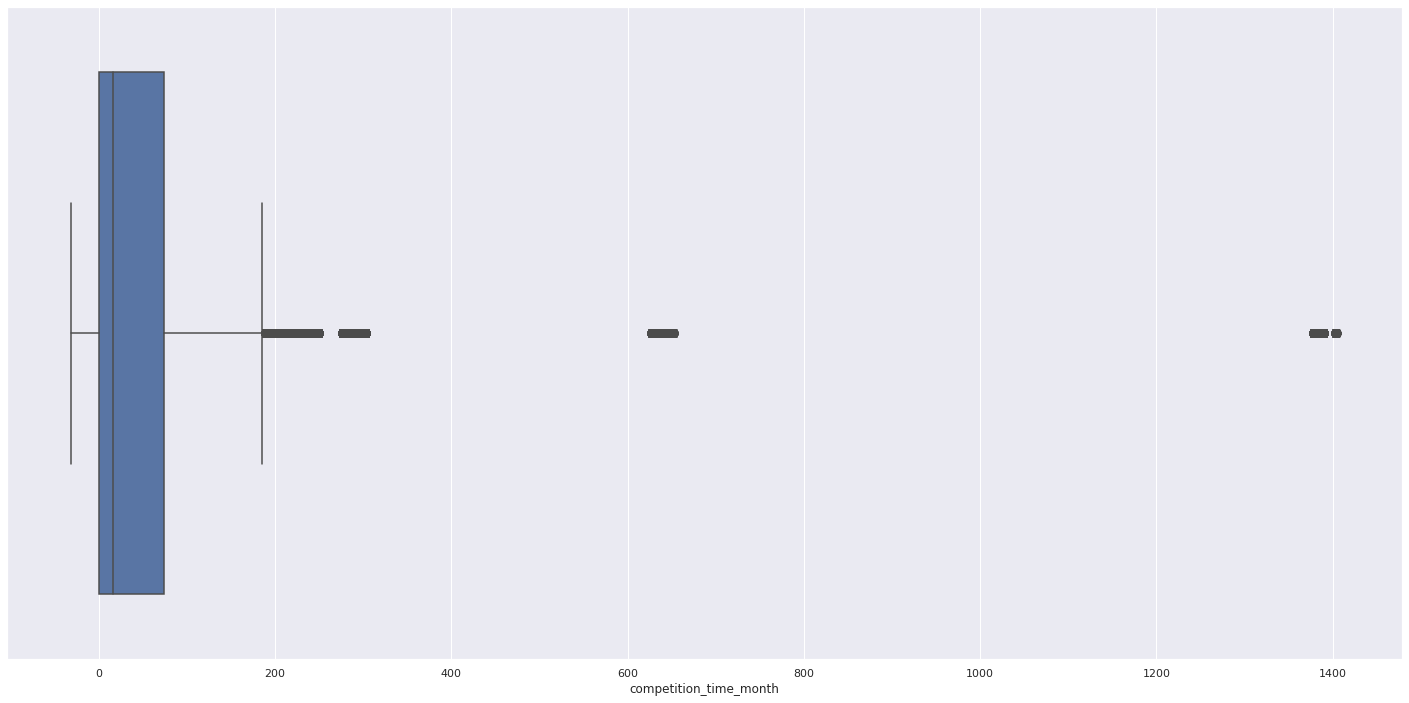

In [83]:
#outliers bem definidos em competition_time_month - usar robust scaler
sns.boxplot(df5['competition_time_month'])

<AxesSubplot:xlabel='promo_time_week'>

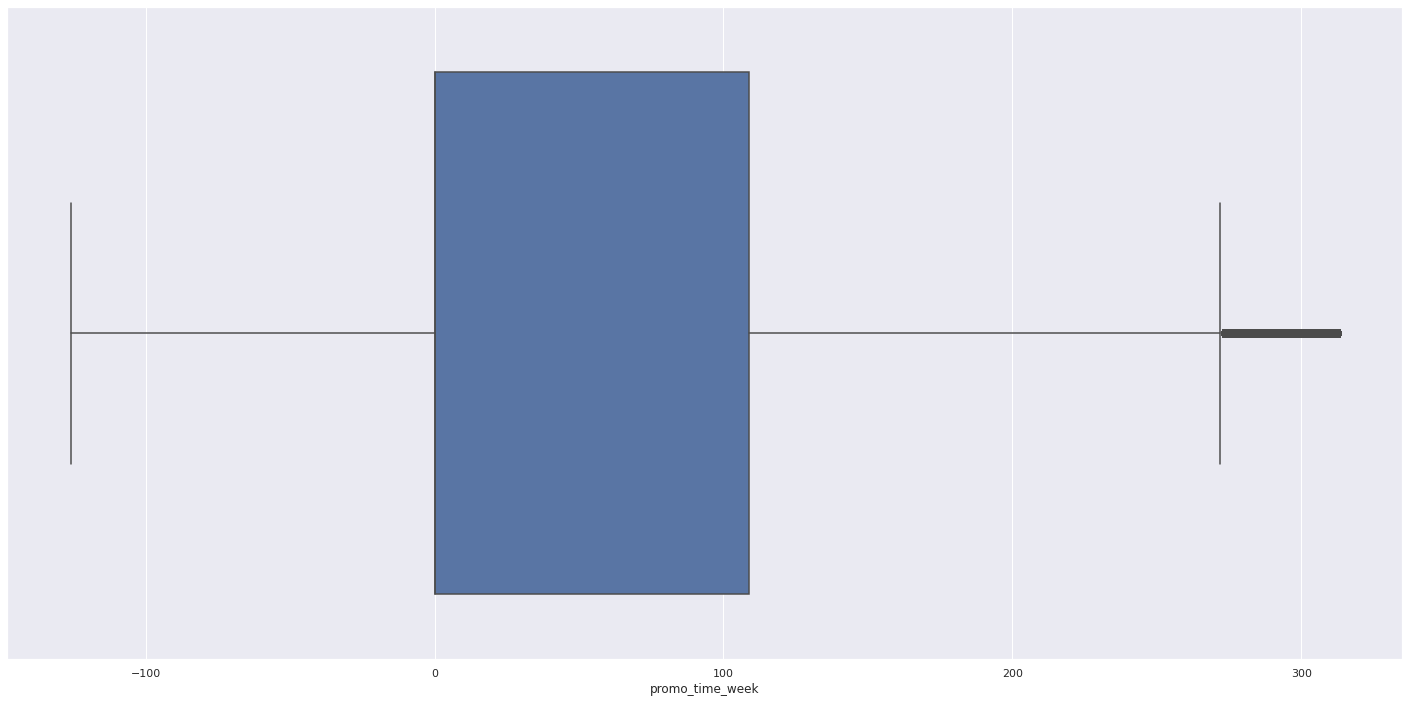

In [84]:
#outliers bem definidos em promo_time_week - outliers não são tão relevantes aqui, então será usado Min-Max Scaler
sns.boxplot(df5['promo_time_week'])

In [85]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

FileNotFoundError: [Errno 2] No such file or directory: 'parameter/competition_distance_scaler.pkl'

In [ ]:
sns.distplot(df5['competition_distance'])

## 5.3 Transformacao

### 5.3.1 Encoding

In [86]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df4,prefix=['state_holiday'],columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( 'webapp/parameter/store_type_scaler.pkl', 'wb') )

#assortment - Ordinal Encoding
#basic <  extra < extended 
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [87]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

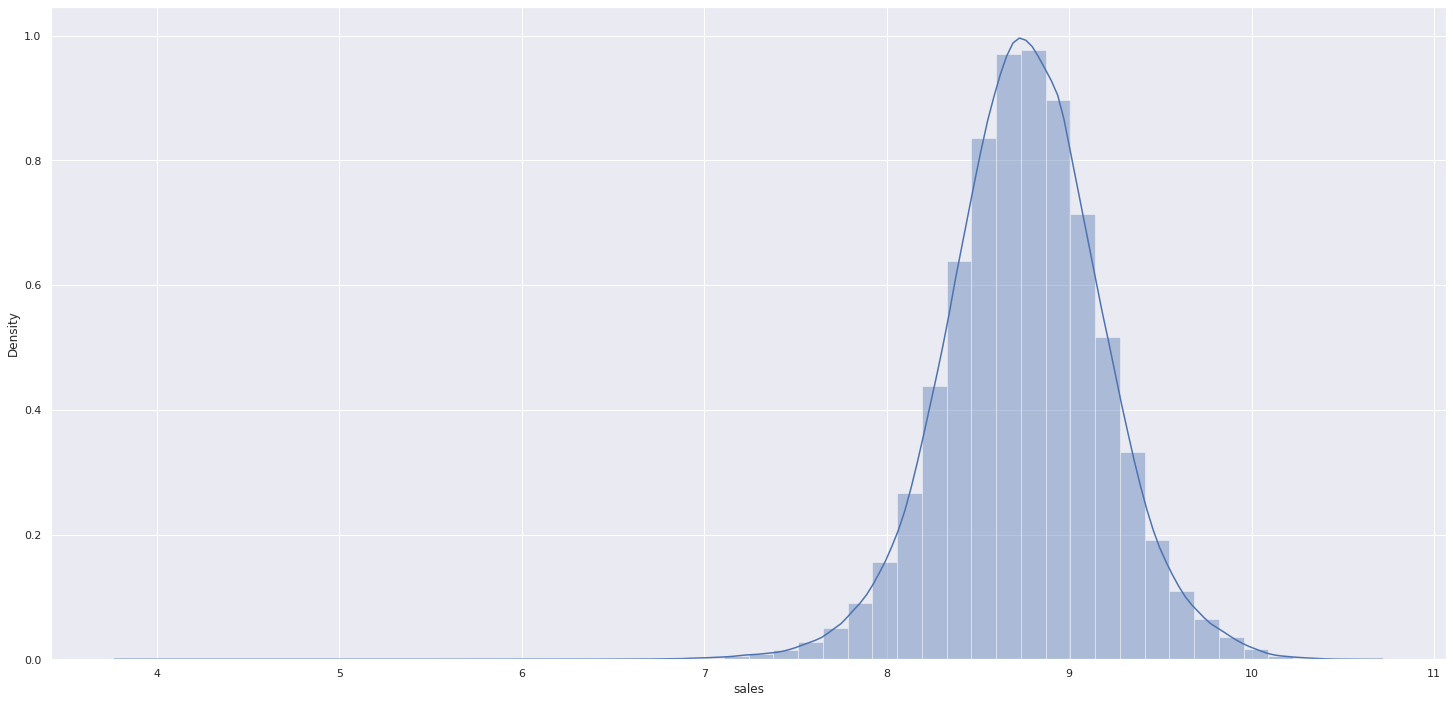

In [88]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [89]:
#variaveis ciclicas
#o 7 indica o tamanho do ciclo(7 dias da semana)
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x*(2.* np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x*(2.* np.pi/7)))


#month
#o doze indica o tamanho do ciclo(12 meses)
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x*(2.* np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x*(2.* np.pi/12)))

#day
#o 30 indica o tamanho do ciclo(30 dias do mes)
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x*(2.* np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x*(2.* np.pi/30)))

#week of year
#o 52 indica o tamanho do ciclo(52 semanas do ano)
df5['week_of_year_sin'] = df5['day'].apply( lambda x: np.sin(x*(2.* np.pi/52)))
df5['week_of_year_cos'] = df5['day'].apply( lambda x: np.cos(x*(2.* np.pi/52)))

In [90]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. (Passo 6) FEATURE SELECTION

In [91]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [92]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [93]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

In [94]:
#vou separar os ultimos 6 meses para ser os dados de teste
df6[['store','date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [95]:

df6[['store','date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
5,6,2015-07-31
6,7,2015-07-31
7,8,2015-07-31
8,9,2015-07-31
9,10,2015-07-31


In [96]:
#subtraindo 6 semanas da data maxima
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [97]:
#training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('training min date: {}'.format(x_train['date'].min()))
print('training max date: {}'.format(x_train['date'].max()))

print('\ntest min date: {}'.format(x_test['date'].min()))
print('test max date: {}'.format(x_test['date'].max()))


training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

test min date: 2015-06-19 00:00:00
test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [98]:
# #training and test dataset for Boruta
# #dropando colunas de teste
# x_train_n = x_train.drop(['date','sales'],axis=1).values
# #ravel coloca tudo dentro de um vetor
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor, n_jobs = -1 usa todos os cores da maquina e assim faz processamento em paralelo
# rf = RandomForestRegressor (n_jobs = -1)


# # define Boruta
# # classe Boruta, rf = random forest ,verbose = 2 printa o processo,random_state crava o inicio da aleatoriedade, pode ser qualquer numero,x_train_n e y_train_n  são vetores de numero 
# boruta = BorutaPy(rf, n_estimators = 'auto',verbose=2,random_state = 42).fit(x_train_n,y_train_n)

### 6.2.1 Best Features from Boruta

In [99]:
# #suporte é o valor do rank do algoritmo
# cols_selected = boruta.support_.tolist() #vetor de numeros
# x_train_fs = x_train.drop(['date','sales'],axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected] #iloc trabalha com index 

### workaround for Boruta

In [100]:
x_train.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [101]:
cols_selected_boruta = ['store',  'promo', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'competition_time_month',
       'promo_time_week','day_of_week_sin', 'day_of_week_cos', 
       'month_cos', 'day_sin', 'day_cos',
       'week_of_year_cos']

In [102]:
#Resumo das hipoteses
# Hipotese | Conclusão | Relevância
# H1         Falsa       Baixa    
# H2         Falsa       Media
# H3         Falsa       Media
# H4         Falsa       Baixa
# H5         -           -
# H7         Falsa       Baixa
# H8         Falsa       Media
# H9         Falsa       Alta
# H10        Falsa       Alta
# H11        Verdadeira  Alta
# H12        Verdadeira  Alta
# H13        Verdadeira  Baixa
#
# Foi visto que na análise exploratoria dos dados o ano é importante , porém para o Boruta não é, nesse caso a desição é do cientista de dados.
# Uma dica como está sendo executada a primeira rodada do Crisp usar o resultado do Boruta
# De forma geral as hipoteses foram confirmadas pelo Boruta


## 6.3. Manual Features Selection

In [103]:
# complementando o seno e cosseno que o boruta deixou de fora
# colocar date e sale que foram retirados, pois vai ser utilizado
cols_selected_boruta = [
    'store',  
    'promo', 
    'store_type',
    'assortment', 
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2', 'promo2_since_week',
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos', 
    'day_sin', 
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

#columns to add
feat_to_add = ['date','sales']

#final features
#cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [104]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. (Passo 7) MACHINE LEARNING MODELLING

In [105]:
#lembrar que estou invertendo o X e Y maiusculo visto no treinamento
X_train = x_train[ cols_selected_boruta ]
X_test = x_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = x_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [106]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
#predições
yhat_baseline = aux1['predictions']

# performance
#np.expm1 : As previsões foram feitas fazendo a conversão das variáveis para log. Agora estamos voltando aos valores originais para ser usados nas análises das performances do modelo. O inverso de log é exp
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [107]:
# O Modelo de média é usado para servir de parâmetro para avaliar a eficácia dos demais modelos  

In [108]:
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.443762,1,0,2,1,1270.0,9,2008,0,25,2015,0,2015,82,0,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.822984,-0.568065
47946,2,2015-06-18,8.547722,1,0,0,1,570.0,11,2007,1,13,2010,0,2015,92,273,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.822984,-0.568065
47947,3,2015-06-18,8.927712,1,0,0,1,14130.0,12,2006,1,14,2011,0,2015,104,220,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.822984,-0.568065
47948,4,2015-06-18,9.091669,1,0,2,3,620.0,9,2009,0,25,2015,0,2015,70,0,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.822984,-0.568065
47949,5,2015-06-18,8.502080,1,0,0,1,29910.0,4,2015,0,25,2015,0,2015,2,0,0,0,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.822984,-0.568065


## 7.2. Linear Regression Model

In [116]:
# model
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1876.27178,0.293135,2671.34541


In [ ]:
# É perceptivel através do erro RMSE que o modelo linear tem um erro muito maior que o modelo de média, ou seja, isso mostra que o modelo de média é melhor e que meus dados tem um comportamento complexo não linear. Devemos partir para modelos não lineares.

### 7.2.1. Linear Regression Model - Cross Validation

In [117]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2068.7 +/- 297.0,0.3 +/- 0.02,2932.12 +/- 465.27


## 7.3. Linear Regression  Regularized Model -Lasso

In [120]:
# model
# alpha -> valor que indica de quanto o peso deve ser multiplicado. Isso faz os valores ficarem dentro de um range que você quer.
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )

# prediction
yhat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.285926,0.294716,2720.25433


In [ ]:
# É perceptivel através do erro RMSE que o modelo linear  regularizado tem um erro muito maior que o modelo de média, ou seja, isso mostra que o modelo de média é melhor e que meus dados tem um comportamento complexo não linear. Devemos partir para modelos não lineares. Pior até que o modelo Linear anterior

### 7.3.1.  Lasso - Cross Validation

In [121]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.02 +/- 343.97,0.29 +/- 0.01,3047.59 +/- 509.63


## 7.4. Random Forest Regressor

In [122]:
# model
# n_estimators -> quantas arvores aleatórias ele vai criar
# n_jobs=-1 -> para rodar em paralelo e usar todos os cores do processador
# random_state=42 -> parte da mesma origem aleatória, pode ser qualquer  número
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,692.157653,0.103049,1025.797568


### 7.4.1.  Random Forest Regressor - Cross Validation

In [123]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,850.02 +/- 230.95,0.12 +/- 0.02,1269.92 +/- 328.94


## 7.5. XGBoost Regressor

In [124]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=500, 
                              eta=0.01, # quantas passsadas é usada para fazer o aprendizado
                              max_depth=20, # maxima ramificação que a arvore pode chegar
                              subsample=0.7, # porcentagem de todas as variaveis que eu tenho para fazer amostragem
                              colsample_bytree=0.9 # random forest são varias arvores isso faz esse sample em cada uma das arvores
                            ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,899.195814,0.118035,1326.329024


### 7.5.1. XGBoost Regressor - Cross Validation


In [125]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1116.48 +/- 193.26,0.14 +/- 0.01,1605.1 +/- 283.35


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [126]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,692.157653,0.103049,1025.797568
0,XGBoost Regressor,899.195814,0.118035,1326.329024
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1876.271780,0.293135,2671.345410
0,Linear Regression - Lasso,1890.285926,0.294716,2720.254330


### 7.6.2. Real Performance - Cross Validation

In [127]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2068.7 +/- 297.0,0.3 +/- 0.02,2932.12 +/- 465.27
0,Lasso,2113.02 +/- 343.97,0.29 +/- 0.01,3047.59 +/- 509.63
0,Random Forest Regressor,850.02 +/- 230.95,0.12 +/- 0.02,1269.92 +/- 328.94
0,XGBoost Regressor,1116.48 +/- 193.26,0.14 +/- 0.01,1605.1 +/- 283.35


## 7.7. Machine Learning results from (7.6.2. Real Performance - Cross Validation)

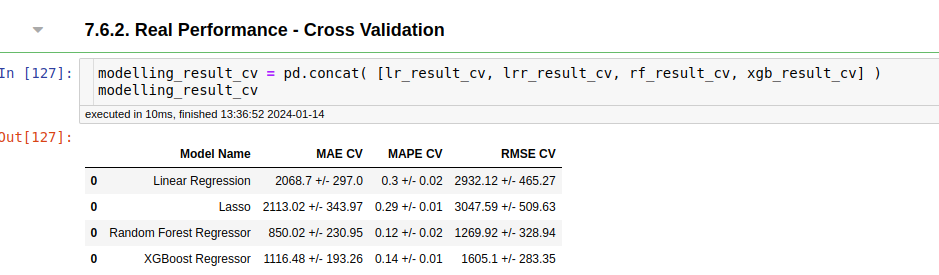

In [129]:
Image('img/ML-results.png')

# 8.0. (Passo 8) HYPERPARAMETER FINE TUNING

## 8.1. Random Search


In [130]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [131]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
# model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=500, 
#                               eta=0.01, # quantas passsadas é usada para fazer o aprendizado
#                               max_depth=20, # maxima ramificação que a arvore pode chegar
#                               subsample=0.7, # porcentagem de todas as variaveis que eu tenho para fazer amostragem
#                               colsample_bytree=0.9 # random forest são varias arvores isso faz esse sample em cada uma das arvores
#                             ).fit( X_train, y_train )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        

## 8.1. Final Model


In [132]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [133]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'], 
                              eta=param_tuned['eta'],  # quantas passsadas é usada para fazer o aprendizado
                              max_depth=param_tuned['max_depth'], # maxima ramificação que a arvore pode chegar
                              subsample=param_tuned['subsample'], # porcentagem de todas as variaveis que eu tenho para fazer amostragem
                              colsample_bytree=param_tuned['colsample_bytree'],# random forest são varias arvores isso faz esse sample em cada uma das arvores
                              min_child_weight=param_tuned['min_child_weight'] ).fit( X_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,773.322719,0.117419,1105.737558


## 8.2. Final Model

In [134]:
# param_tuned = {
#     'n_estimators': 3000,
#     'eta': 0.03,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3 
#         }

In [135]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

In [136]:
# mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# mpe

## 8.3. Final Model ( Para efeito de continuar o treinamento )

#### Como iria demorar 30 horas para treinar o modelo ecom os valores de param_tuned vou assumir  os valores abaixo
#### Porém deve ser feito quando o passo a rigor em um modelo real ou de portifolio

In [137]:
param_tuned = {
    'n_estimators': 500,
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [138]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( X_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,764.663963,0.112851,1115.913874


In [139]:
#salvando  o modelo para não rodar novamente

In [140]:
#pickle.dump(yhat_xgb_tuned,open('/home/felipe/Documents/DS_em_Producao/ds_em_producao/model/model_rossmann.pkl','wb'))
pickle.dump(model_xgb_tuned,open('/home/felipe/Documents/DS_em_Producao/ds_em_producao/model/model_rossmann1.pkl','wb'))

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [141]:
df9 = x_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performance

In [142]:
# sum of predictions
# pq store? pq o problema é o CEO querer saber a previsão de cada loja para efetuar a reforma das lojas
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [143]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,113852.43750,110372.034668,117332.840332,3480.402832,0.658803
908,909,218948.93750,211051.504437,226846.370563,7897.433063,0.515849
434,435,146477.21875,145509.212660,147445.224840,968.006090,0.334592
875,876,195785.68750,191691.073773,199880.301227,4094.613727,0.318140
594,595,360259.46875,355693.156712,364825.780788,4566.312038,0.307943


## 9.2. Total Performance

In [144]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$284,010,304.00"
1,worst_scenario,"R$283,154,415.40"
2,best_scenario,"R$284,866,148.89"


## 9.3. Machine Learning Performance

In [145]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


<AxesSubplot:xlabel='predictions', ylabel='error'>

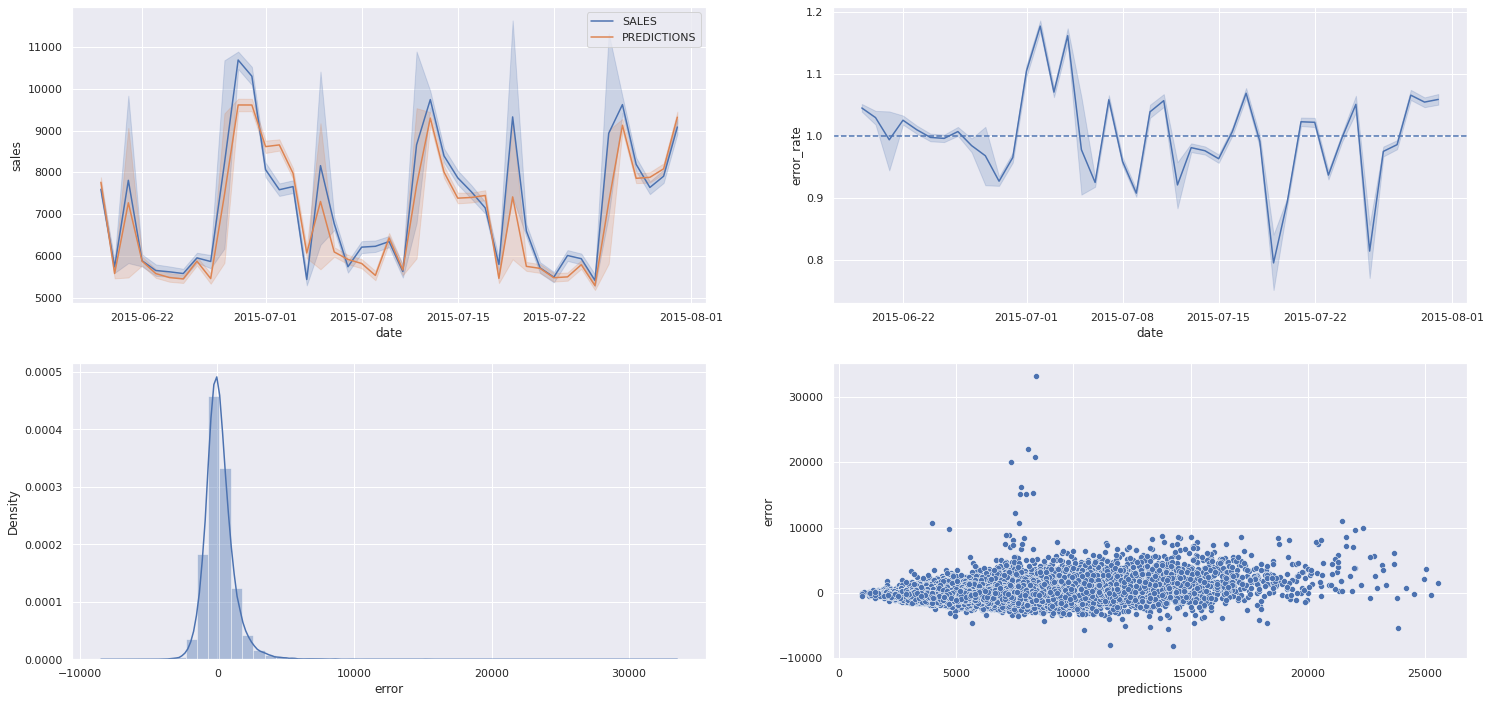

In [146]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )


In [147]:
#interpretação dos graficos
# no primeiro grafico o laranja são as predições e o azul os valores de venda real. É perceptivel que o predito é bem próximo do real.
#o segundo  error rate é a predição dividida pelas vendas ou seja. Se for igual a 1 tenho a predição perfeita. Se a variação for acima do 1 tenho uma superestimação. Se for menor que 1 tenho uma subestimação.
# o terceiro grafico mostra a distribuição do erro proximo da ndistribuição normal o que é bom.
#no quarto gráfico temos um gráfico usado em análise de resíduo( não abordado no treinamento. É uma teoria que mostra o que precisa ser feito para melhorar a acurácia do modelo). O gráfico mostra as previsões em relação ao erro mostra que valores de predições em torno de 7-9 mil 
#temos os erros maiores. O correto seria o modelo ficar proximo de um tubo (faixa continua) o que se mostra no gráfico acima na maioria dos valores.

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [148]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/home/felipe/Documents/DS_em_Producao/ds_em_producao/model/model_rossmann1.pkl', 'wb' ) )

In [149]:
# o picle foi usado os passos anteriores para ser recuperado a seguir

## 10.1. Rossmann Class


In [119]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/felipe/Documents/DS_em_Producao/ds_em_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns 
        # sem sales ( quero prever) e customers não tem como prever o numero de customers nas proximas semanas
        # ao longo da sessão foi feita a modificação no código original para eliminar qualquer trecho de código que manipulava a coluna sales ou custoemr
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data para poder retornar o dado original com a coluna nova prediction
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler


In [120]:
# se rodar o trecho abaixo não dara certo pq tem que colocar a classe no arquivo ahndler.py

In [123]:
import pickle
import pandas as pd
# flask conjunto de funções para lidar com ambiente WEB
from flask             import Flask, request, Response
# importando a classe: rossman minusculo é a pasta from é o pacote e import é o nome da classe
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/felipe/Documents/DS_em_Producao/ds_em_producao/model/model_rossmann1.pkl', 'rb') )

# initialize API (passo 1)
#instancia a classe Flask
app = Flask( __name__ )

#(passo 3) define o endpoint e define o metodo post para receber métodos  que envia dados para poder receber
# e não get onde ele pede alguma coisa
@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    #pegando o dado enviado da API
    test_json = request.get_json()
   #testando se veio dado do POST
    if test_json: # there is data!
        # converte o dado em dataframe e inicia o index =0
        if isinstance( test_json, dict): #testa se veio unico # unique example ( ou seja vem um único jason ai consegue converter em um dataframe)
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example ( nesse caso vem vários jason) para ser convertido em dataframe
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )# test_json[0].keys() esses são os valores da coluna
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        #test_raw é passado para voltar o dado original para a pessoa e df3 é o dado tranformado para fazer a predição
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else: # quando não vem dadao da requisição, identifica que não tem dado e retorna vazio
        return Reponse( '{}', status=200, mimetype='application/json' )

    #quando rodado o script o interpretador vai procurar a função main dentro do script
    # quando encontrada é rodado o flask no endpoint 0.0.0.0(localhost) (passo 2)
if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( '/home/felipe/Documents/DS_em_Producao/ds_em_producao/data/test.csv' )

In [ ]:
# merge test dataset + store .O arquivo test tem apenas a performance das lojas , o arquivo store tem a caracteristica das lojas
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction escolhendo algumas lojas para fazer a previsão e não  todas
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days removendo as linhas onde as lojas estão fechadas pois não ajuda na predição
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 ) #id não usa pra nada

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) ) # orientação records cada linha é um jason e o arquivo final é uma lista de jasons

In [ ]:
data

In [ ]:
# colocando o servidor no ar 


# no terminal com a env ativa criar pasta api
# mkdir -p api/rossmann
# entrar em api:
#cd api
# touch handler.py # touch cria um arquivo vazio
# touch rossmann/Rossmann.py
# retornar as sessões 10.1 e 10.2 e fazer alterações no código
# depois de tudo certo colocar a API no ar
# python handler.py








In [ ]:
# depois de startar o servidor rodar o código abaixo

In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test-fhs.herokuapp.com/rossmann/predict'
#indica o tipo de dado que está recebendo
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1.head()

In [ ]:
#soma do que será vendido ao final das 6 semanas
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )